## High-z galaxies with Te measurements

# Strong line methods Analysis

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from lmfit import minimize, Parameters
from astropy.table import Table
from astropy.visualization import hist
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import MultipleLocator
from numpy.polynomial import polynomial as P
import numpy.polynomial.polynomial as poly
import pickle
plt.rcParams.update({'font.size': 12})

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

In [2]:
## Functions to calculate the error bars in the strong line methods
def minimise_func(params,R,calib,calib_err=1.):
    return (calib(params['met'])*calib_err-R)

def err_ratio(x,y,e_x,e_y):
    """ Formal Error of x/y """
    return x/y * np.sqrt((e_x/x)**2 + (e_y/y)**2)

def err_R23(x1,x2,x3,y,ex1,ex2,ex3,ey):
    """ Formal Error of (x1+x2+x3)/y """
    return 1/y*np.sqrt((ex1*ex1+ex2*ex2+ex3*ex3) + ey*ey/y**2*(x1+x2+x3)**2)

# MC paramters
MC_steps = 500
def perturbed_lines(f):
    ''' Return a new line flux dictionary with the original fluxes perturbed 
    within the observational error. If line is only an upper limit, does not 
    vary it.'''
    np.random.seed()
    new_lines = {}
    for line in line_names:
        if np.isfinite(f[line]) and np.isfinite(f['e'+line]):
            new_lines[line] = np.random.normal(f[line],f['e'+line])
        else: # If there is only a detection limit (no error bar)
            new_lines[line] = f[line]
            
    return new_lines


def bootstrap(data,nb,func):
    sample = [np.random.choice(data,len(data)) for i in range(nb)]
    if func == 'mean':
        return np.std(map(np.mean,sample))
    if func == 'std':
        return np.std(map(np.std,sample))
    if func == 'mae':
        return np.std(map(mean_absolute_error,np.zeros_like(sample),sample))

# Calculate Line Ratios 


Number of samples: R23 500, N2 290, O32 490, O3 500, O2 490, O3N2 290, Ne3O2 490, Ne3O3 500


<IPython.core.display.Javascript object>


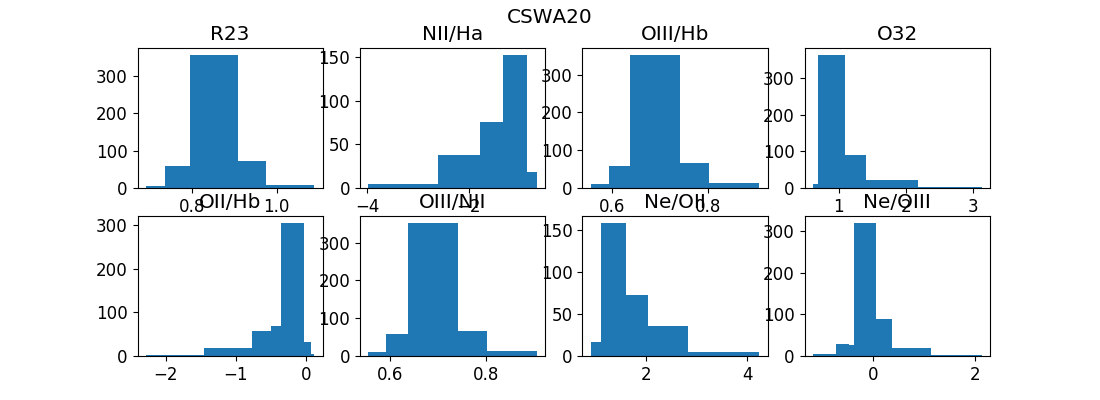

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


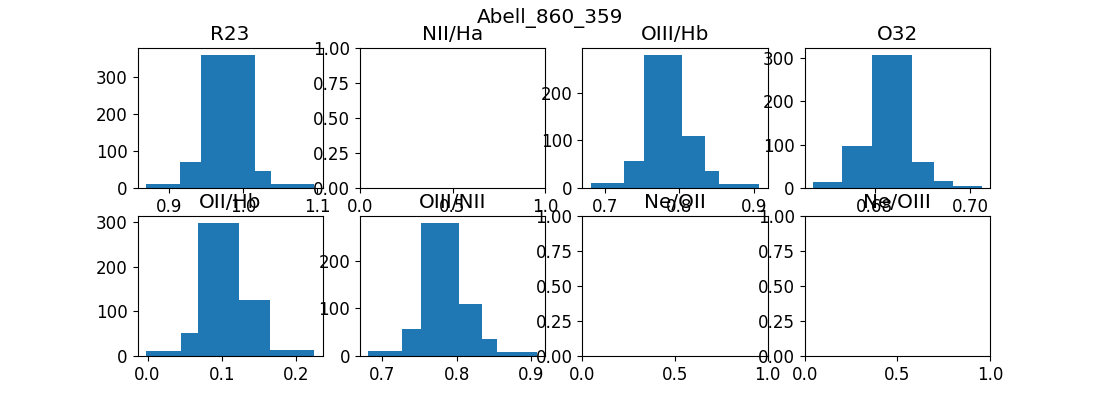

Number of samples: R23 500, N2 500, O32 500, O3 500, O2 500, O3N2 500, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


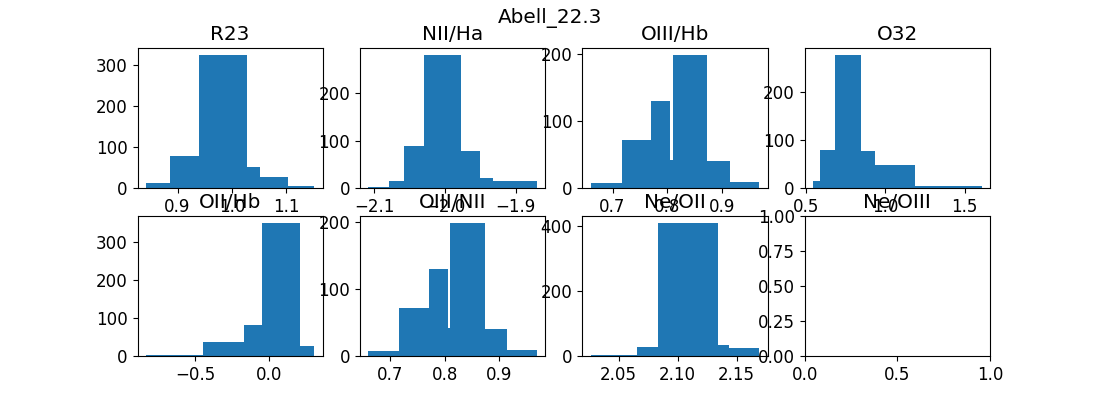

Number of samples: R23 500, N2 500, O32 500, O3 500, O2 500, O3N2 500, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


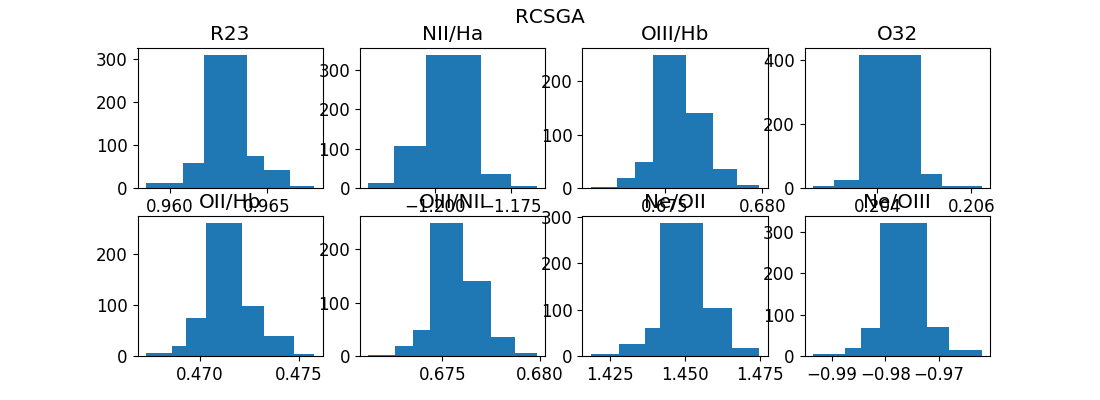

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


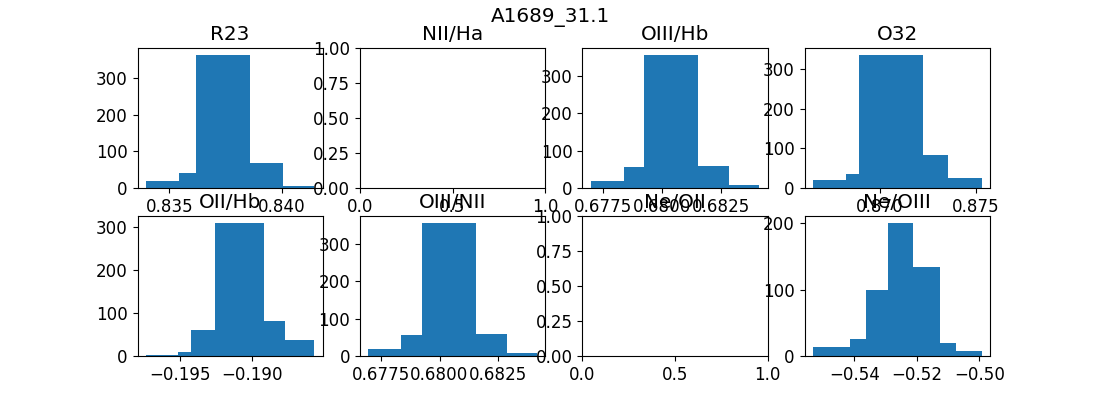

Number of samples: R23 500, N2 395, O32 500, O3 500, O2 500, O3N2 395, Ne3O2 269, Ne3O3 269


<IPython.core.display.Javascript object>


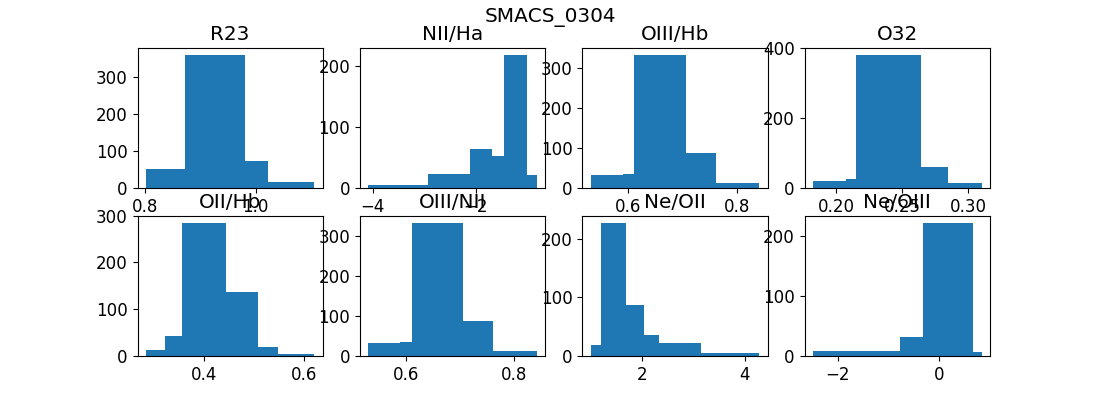

Number of samples: R23 500, N2 500, O32 500, O3 500, O2 500, O3N2 500, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


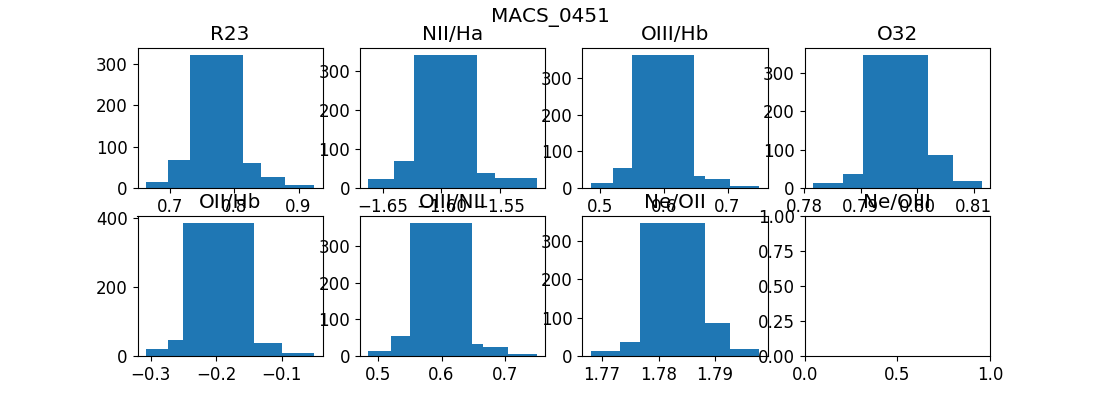

Number of samples: R23 500, N2 500, O32 500, O3 500, O2 500, O3N2 500, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


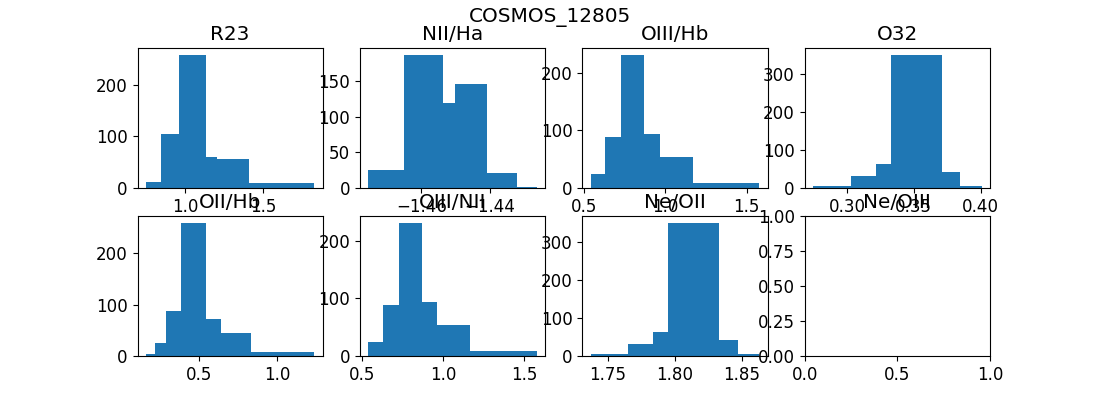

Number of samples: R23 500, N2 500, O32 500, O3 500, O2 500, O3N2 500, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


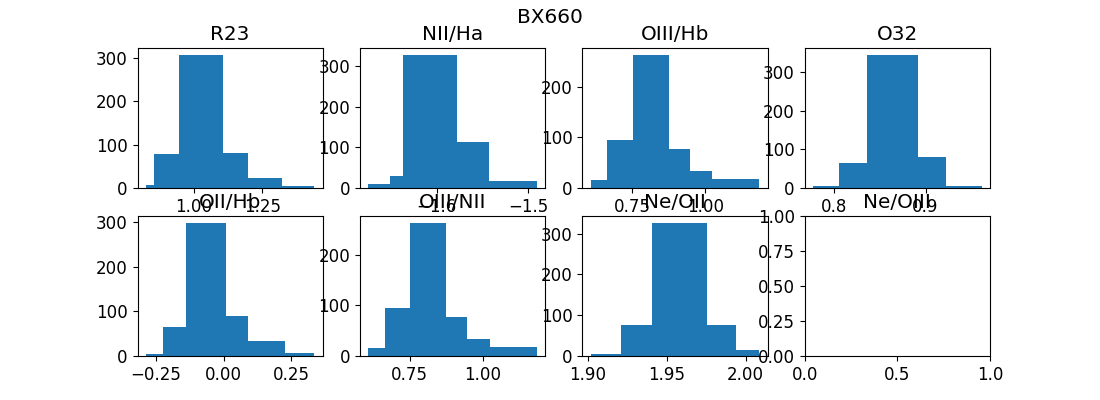

Number of samples: R23 500, N2 365, O32 500, O3 500, O2 500, O3N2 365, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


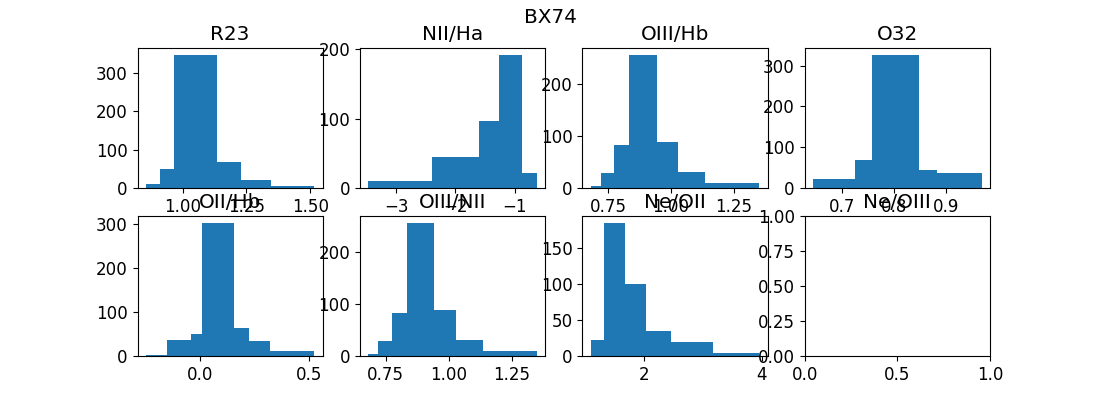

Number of samples: R23 500, N2 393, O32 500, O3 500, O2 500, O3N2 393, Ne3O2 0, Ne3O3 0


<IPython.core.display.Javascript object>


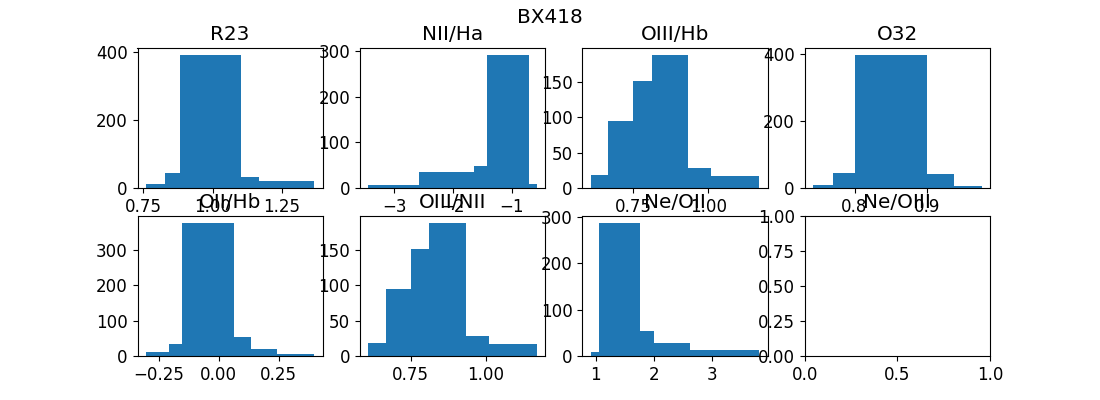

Number of samples: R23 500, N2 494, O32 500, O3 500, O2 500, O3N2 494, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


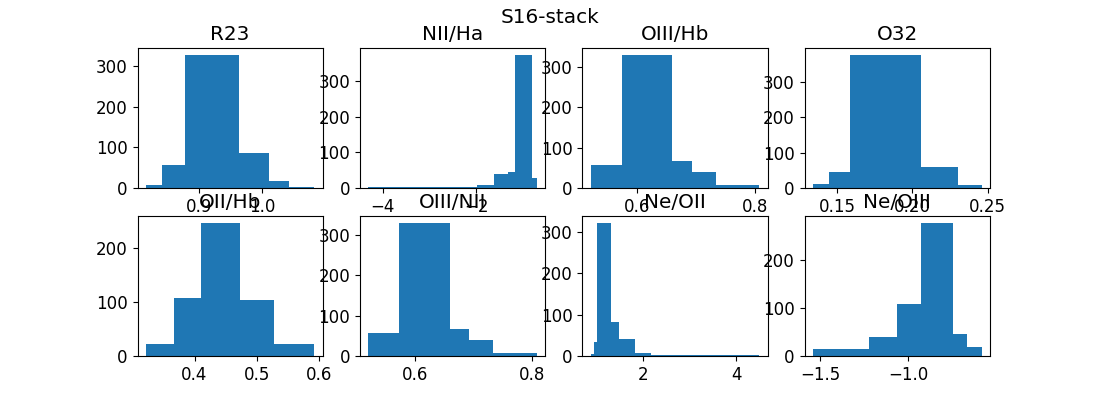

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


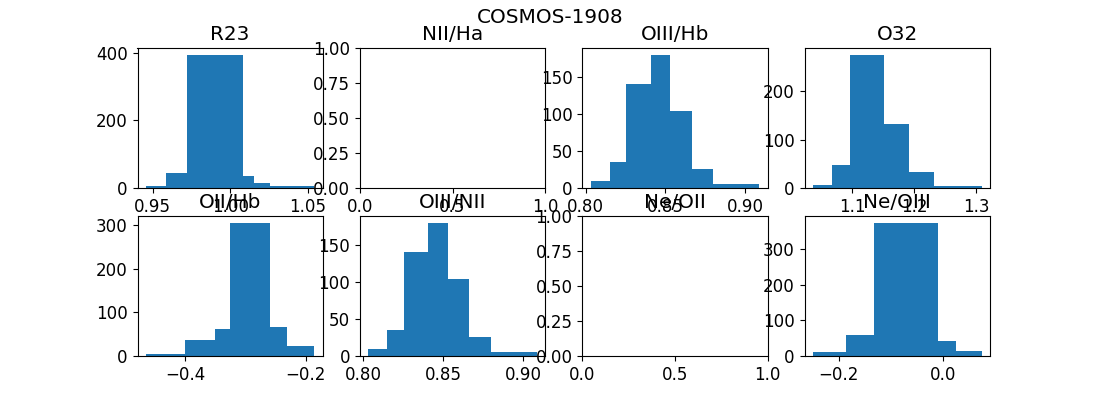

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 488, Ne3O3 488


<IPython.core.display.Javascript object>


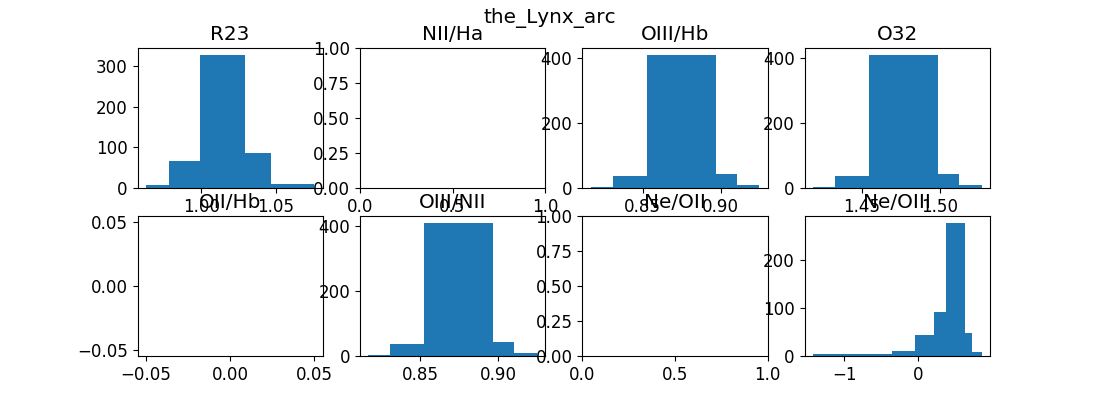

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


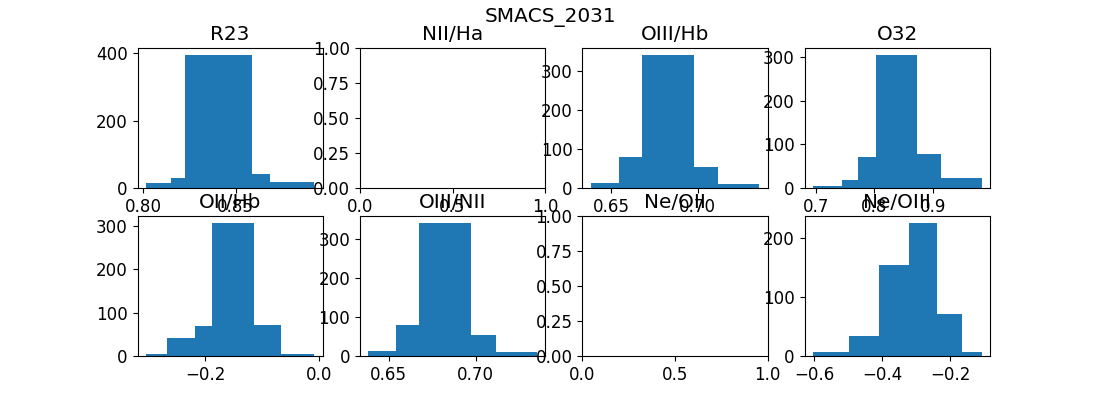

Number of samples: R23 500, N2 0, O32 500, O3 500, O2 500, O3N2 0, Ne3O2 500, Ne3O3 500


<IPython.core.display.Javascript object>


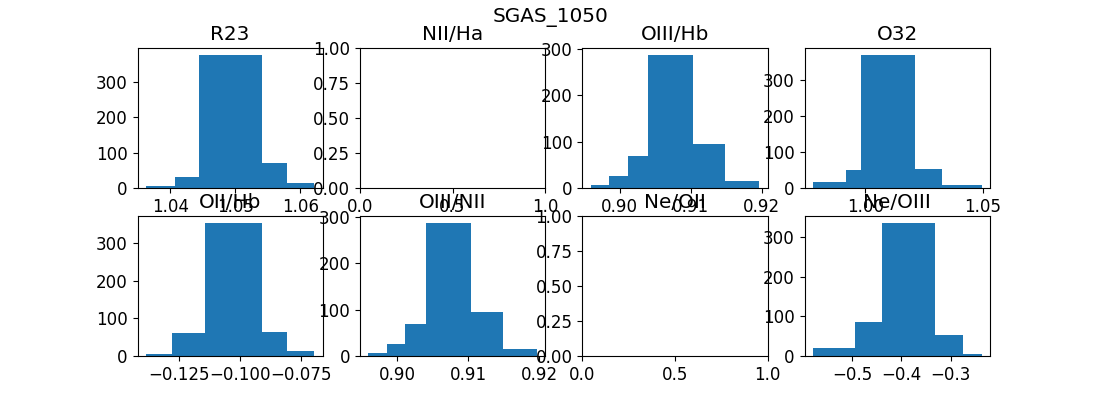

In [3]:
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')
gal = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
gal.add_index('Name')

#Initialise table to save results
line_ratios = Table(names=['Name',
                           'R23','NII_Ha','OIII_Hb','O32','OII_Hb','OIII_NII','Ne_OII','Ne_OIII',
                           'upR23','upNII_Ha','upOIII_Hb','upO32','upOII_Hb','upOIII_NII','upNe_OII','upNe_OIII',
                           'lowR23','lowNII_Ha','lowOIII_Hb','lowO32','lowOII_Hb','lowOIII_NII','lowNe_OII','lowNe_OIII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4', 'f4','f4', 'f4','f4','f4','f4', 'f4','f4', 'f4',
                                'f4', 'f4','f4','f4','f4', 'f4','f4','f4', 'f4','f4'))


MC_steps = 500

for f_init in dered_fluxes:
    
    R23_sample = []
    NII_Ha_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    OIII_NII_sample =[]
    Ne_OII_sample = []
    Ne_OIII_sample = []


    for i in range(MC_steps):
        
        f = perturbed_lines(f_init)   
        
        R23_sample.append(np.log10((f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']))
        NII_Ha_sample.append(np.log10(f['NII6584']/f['Ha']))
        O32_sample.append(np.log10(f['OIII5007']/f['OIITot']))
        OIII_Hb_sample.append(np.log10(f['OIII5007']/f['Hb']))            
        OII_Hb_sample.append(np.log10(f['OIITot']/f['Hb']))
        OIII_NII_sample.append(np.log10(f['OIII5007']/f['NII6584']))
        Ne_OII_sample.append(np.log10(f['NeIII3869']/f['OIITot']))
        Ne_OIII_sample.append(np.log10(f['NeIII3869']/f['OIII5007']))
    
    
    # Clean nans
    R23_sample = np.array(R23_sample)[np.isfinite(R23_sample)]
    NII_Ha_sample = np.array(NII_Ha_sample)[np.isfinite(NII_Ha_sample)]
    O32_sample = np.array(O32_sample)[np.isfinite(O32_sample)]
    OIII_Hb_sample = np.array(OIII_Hb_sample)[np.isfinite(OIII_Hb_sample)]
    OII_Hb_sample = np.array(OII_Hb_sample)[np.isfinite(OII_Hb_sample)]
    OIII_NII_sample = np.array(OIII_NII_sample)[np.isfinite(OIII_NII_sample)]
    Ne_OII_sample = np.array(Ne_OII_sample)[np.isfinite(Ne_OII_sample)]
    Ne_OIII_sample = np.array(Ne_OIII_sample)[np.isfinite(Ne_OIII_sample)]
    print('Number of samples: R23 %d, N2 %d, O32 %d, O3 %d, O2 %d, O3N2 %d, Ne3O2 %d, Ne3O3 %d'
         %(len(R23_sample),len(NII_Ha_sample),len(O32_sample),len(OIII_Hb_sample),len(OII_Hb_sample),
           len(OIII_NII_sample),len(Ne_OII_sample),len(Ne_OIII_sample)))

    # Some plots
    fig, ax = plt.subplots(2,4,figsize=(11,4))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    ax[0].set_title('R23')
    ax[1].set_title('NII/Ha')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('OII/Hb')
    ax[5].set_title('OIII/NII')
    ax[6].set_title('Ne/OII')
    ax[7].set_title('Ne/OIII')
    for x,sample in zip(ax,[R23_sample,NII_Ha_sample,OIII_Hb_sample,O32_sample,OII_Hb_sample,OIII_Hb_sample,OIII_NII_sample,Ne_OII_sample,Ne_OIII_sample] ):
        try:
            hist(sample,bins='blocks',ax=x)
        except IndexError:
            pass
 
    # Dump data
    out = {}
    out['R23'] = R23_sample
    out['N2'] = NII_Ha_sample,
    out['O3'] = OIII_Hb_sample
    out['O32'] = O32_sample
    out['O2'] = OII_Hb_sample
    out['O3N2'] = OIII_NII_sample
    out['Ne3O2'] = Ne_OII_sample
    out['Ne3O3'] = Ne_OIII_sample
    pickle.dump(out,open('line_ratios/'+f_init['Name']+'line_ratios.pickle','w'))
    
    # Save to table
    line_ratios.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,84)-np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,84)-np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,84)-np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,84)-np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(NII_Ha_sample,50)-np.nanpercentile(NII_Ha_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(OIII_NII_sample,50)-np.nanpercentile(OIII_NII_sample,16),
        np.nanpercentile(Ne_OII_sample,50)-np.nanpercentile(Ne_OII_sample,16),
        np.nanpercentile(Ne_OIII_sample,50)-np.nanpercentile(Ne_OIII_sample,16)))
                    
line_ratios.write('line_ratios.dat',format='ascii.fixed_width_two_line')

### Upper/Lower limits

In some cases, the line fluxes are only upper or lower limits. This should be done in a more automatic way, but for now I am just flagging them manually. Here is the list:

upper_OII = ['Abell_860_359','MACS_0451','COSMOS_12805']

upper_NII = ['Abell_22.3','MACS_0451','COSMOS_12805','BX660']


(the lynx arc is particularly problematic because Hb is an upper limit, so O32, O2 and O3 are affected) 

### Prepare table for paper

In [4]:
line_ratios = Table.read('line_ratios.dat',format='ascii.fixed_width_two_line')
outfile = open('line_ratios_for_paper','w')

for g in line_ratios:
    outfile.write('%s &'%g['Name']) 
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['R23'],g['upR23'],g['lowR23']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['NII_Ha'],g['upNII_Ha'],g['lowNII_Ha']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['OIII_Hb'],g['upOIII_Hb'],g['lowOIII_Hb']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['O32'],g['upO32'],g['lowO32']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['OII_Hb'], g['upOII_Hb'],g['lowOII_Hb']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['OIII_NII'],g['upOIII_NII'],g['lowOIII_NII']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ &'%(g['Ne_OII'],g['upNe_OII'],g['lowNe_OIII']))
    outfile.write('%0.3f$^{+%0.3f}_{-%0.3f}$ '%(g['Ne_OIII'],g['upNe_OIII'],g['lowNe_OII']))
    outfile.write('\\\\ \n')

outfile.close()

# Maiolino 2008

In [5]:
## Maiolino calibrations. ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def R23_Maiolino2008(met):
    """ From Maiolino+08
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        R23 ratio  ((F([OII]3727) + F([OIII]4959) + F([OIII]5007))/F(Hb))
    """
    c0,c1,c2,c3,c4 =  0.7462, -0.7149, -0.9401, -0.6154, -0.2524
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    #return (polyval(met-8.69,(c0,c1,c2,c3,c4)))

    
def OIII_5007_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in 12 + log (O/H) (has to be converted to 12 + log(O/H)- 8.69)
    Output:
    ------- 
        OIII5007 / H beta ratio 
    """
    c0,c1,c2,c3 =  0.1549, -1.5031, -0.9790, -0.0297
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))
    #return (polyval(met-8.69,(c0,c1,c2,c3)))


def OII_3727_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OII doublet / H beta ratio 
    """
    c0,c1,c2,c3,c4 = 0.5603, 0.0450, -1.8017, -1.8434, -0.6549
    return (10**polyval(met-8.69,(c0,c1,c2)))
    #return (polyval(met-8.69,(c0,c1,c2)))



def OIII_5007_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69 
    Output:
    ------- 
        OIII 5007 / OII doublet 
    """
    c0,c1,c2 = -0.2839, -1.3881, -0.3172
    return (10**polyval(met-8.69,(c0,c1,c2)))
    #return (polyval(met-8.69,(c0,c1,c2)))


def NeIII_3870_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NeIII 3870 / OII doublet 
    """
    c0,c1,c2 = -1.2608, -1.0861, -0.1470
    return (10**polyval(met-8.69,(c0,c1,c2)))
    #return (polyval(met-8.69,(c0,c1,c2)))


def NII_6584_Ha_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NII 6584 / Ha 
    """
    c0,c1,c2,c3,c4 = -0.7732, 1.2357, -0.2811, -0.7201, -0.3330    
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    #return (polyval(met-8.69,(c0,c1,c2,c3,c4)))


def OIII_5007_NII_6584_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OIII 5007 / NII 6584 
    """
    c0,c1,c2,c3 = 0.4520, -2.6096, -0.7170, 0.1347 
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))    
    #return (polyval(met-8.69,(c0,c1,c2,c3)))    

### Calculate maximums for degenerate ratios: R23, O3, O2 

<IPython.core.display.Javascript object>


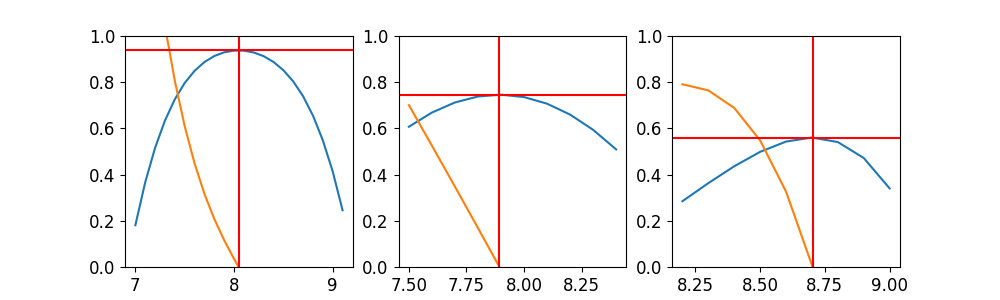

R23 maximum (12+log(O/H),log(R)) = (8.0459,0.9377)
O3 maximum (12+log(O/H),log(R)) = (7.8935,0.7460)
O2 maximum (12+log(O/H),log(R)) = (8.7023,0.5606)


In [6]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

# R23
c0,c1,c2,c3,c4 =  0.7462, -0.7149, -0.9401, -0.6154, -0.2524
deriv = P.polyder(c=(c0,c1,c2,c3,c4),m=1)
met = np.arange(7.,9.2,0.1)
ax[0].plot(met,polyval(met-8.69,(c0,c1,c2,c3,c4)))
ax[0].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[0]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3,c4))
ax[0].axvline(np.real(min_point.real),c='r')
ax[0].axhline(ymax,c='r')
ax[0].set_ylim(0,1.)
print('R23 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O3
c0,c1,c2,c3 =  0.1549, -1.5031, -0.9790, -0.0297
deriv = P.polyder(c=(c0,c1,c2,c3),m=1)
met = np.arange(7.5,8.5,0.1)
ax[1].plot(met,polyval(met-8.69,(c0,c1,c2,c3)))
ax[1].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[1]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3))
ax[1].axvline(np.real(min_point.real),c='r')
ax[1].axhline(ymax,c='r')
ax[1].set_ylim(0,1.)
print('O3 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O2
c0,c1,c2,c3,c4 = 0.5603, 0.0450, -1.8017, -1.8434, -0.6549
deriv = P.polyder(c=(c0,c1,c2,c3,c4),m=1)
met = np.arange(8.2,9.0,0.1)
ax[2].plot(met,polyval(met-8.69,(c0,c1,c2,c3,c4)))
ax[2].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[2]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3,c4))
ax[2].axvline(np.real(min_point.real),c='r')
ax[2].axhline(ymax,c='r')
ax[2].set_ylim(0,1.)
print('O2 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

### Minimising function

Problem: when there are two branched (e.g. R23) we will get both awsers and so the median metallicity will be completelly wrong.

To get error bars, we use MC as usual, since I have no better idea.

We run it twice. Once with the initial metallicity value for the degenerate ratios to be initialised as the metallicity from O32 and other from the direct metallicity. Results are similar.

<IPython.core.display.Javascript object>


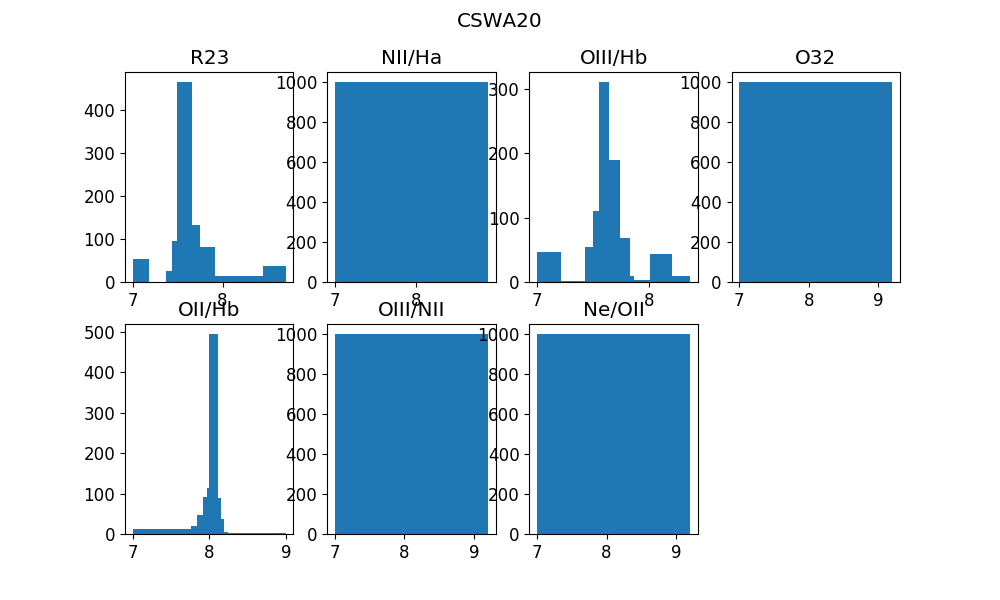

('Nb of R23', 918)
('Nb of O3', 845)
('Nb of O2', 1000)


<IPython.core.display.Javascript object>


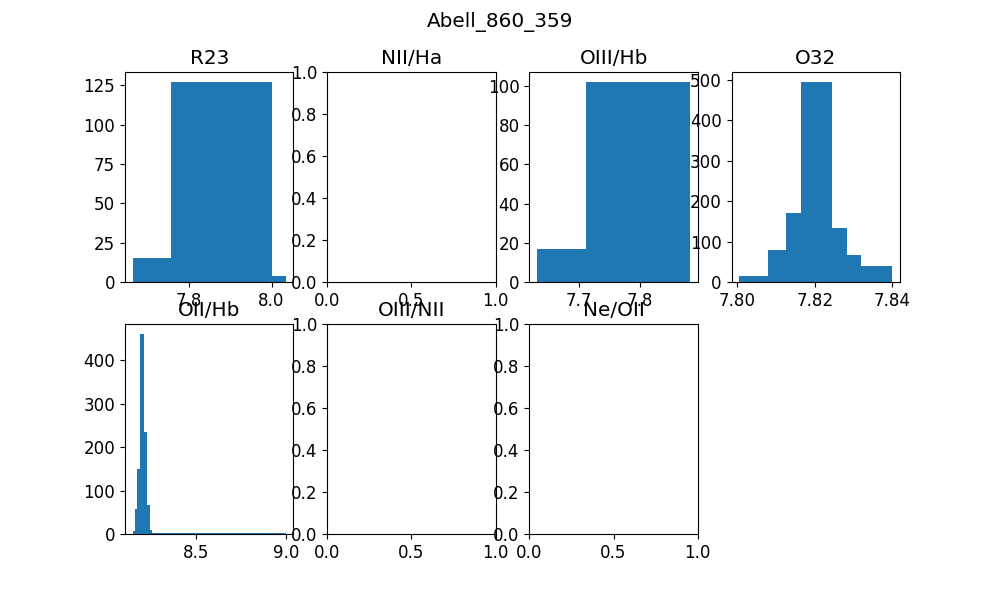

('Nb of R23', 146)
NII_Ha not available
('Nb of O3', 119)
('Nb of O2', 1000)
OIII_NII not available
Ne_OII not available


<IPython.core.display.Javascript object>


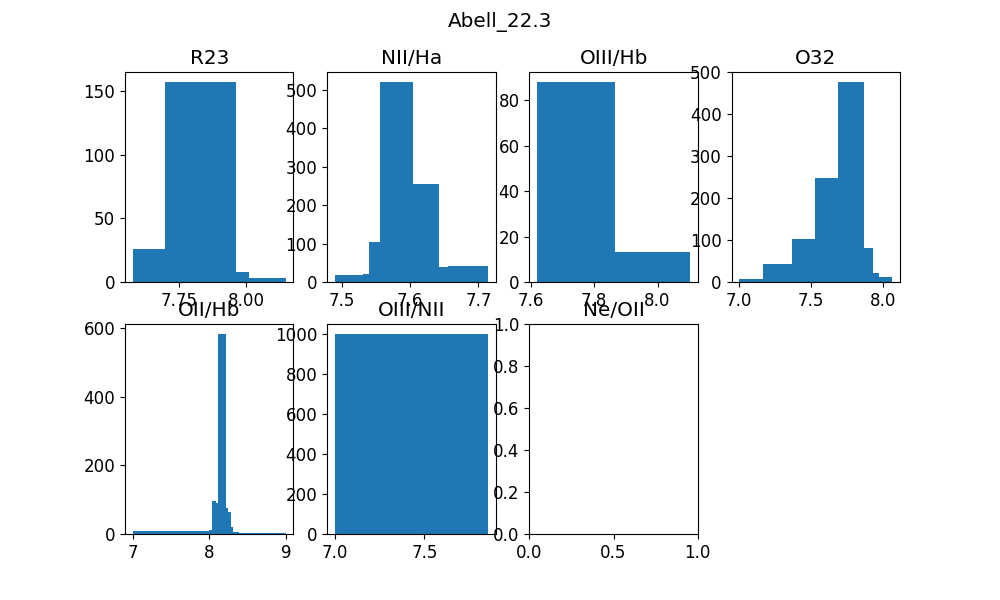

('Nb of R23', 194)
('Nb of O3', 101)
('Nb of O2', 1000)
Ne_OII not available


<IPython.core.display.Javascript object>


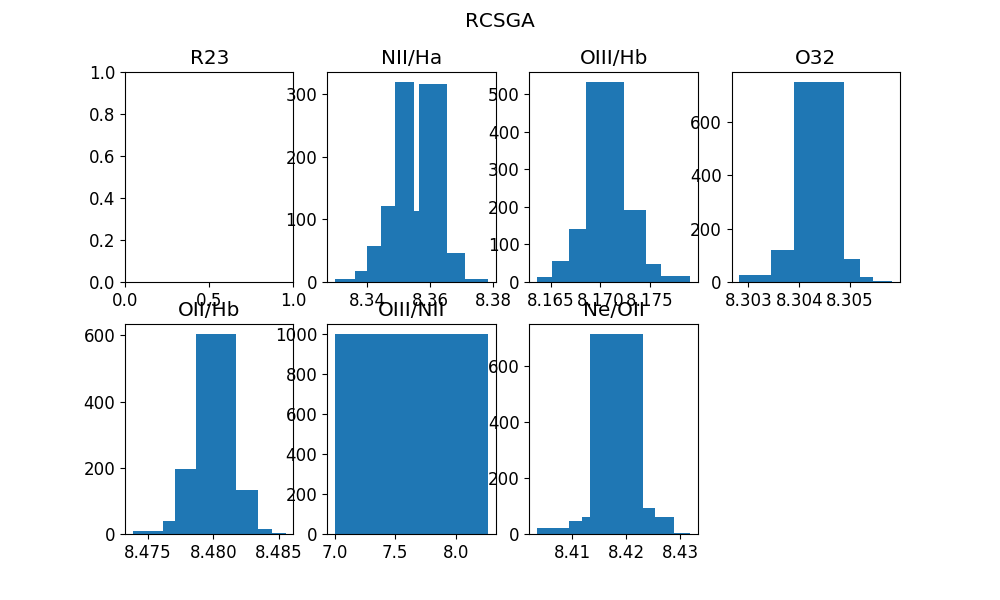

('Nb of R23', 0)
R23 not available for RCSGA
('Nb of O3', 1000)
('Nb of O2', 1000)


<IPython.core.display.Javascript object>


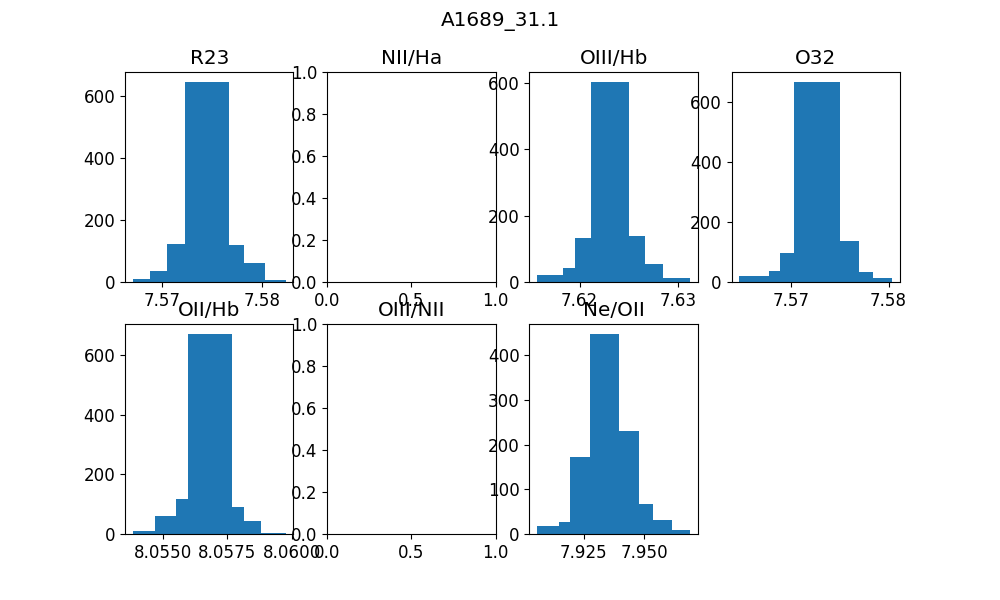

('Nb of R23', 1000)
NII_Ha not available
('Nb of O3', 1000)
('Nb of O2', 1000)
OIII_NII not available


<IPython.core.display.Javascript object>


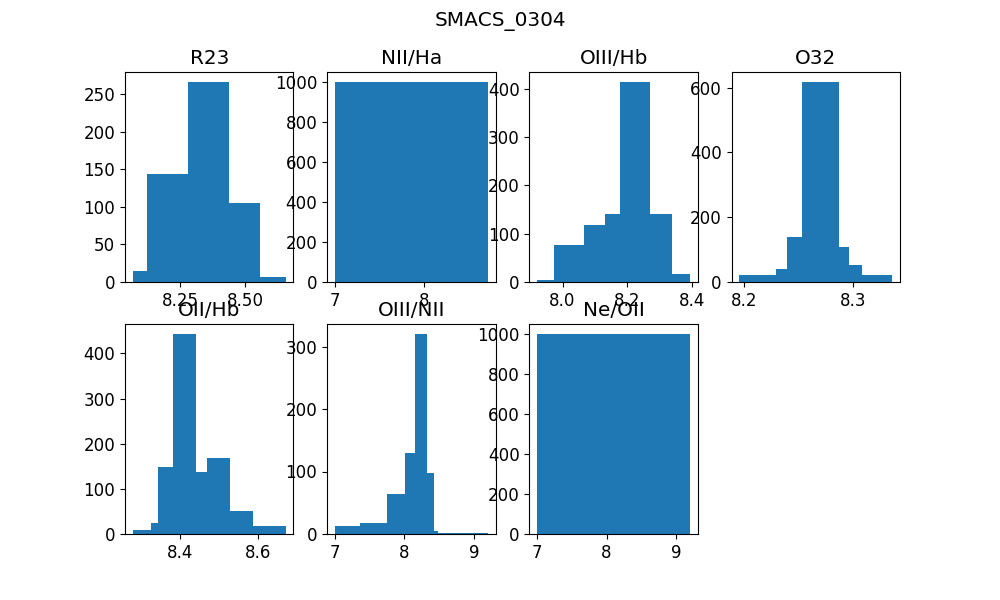

('Nb of R23', 537)
('Nb of O3', 912)
('Nb of O2', 998)


<IPython.core.display.Javascript object>


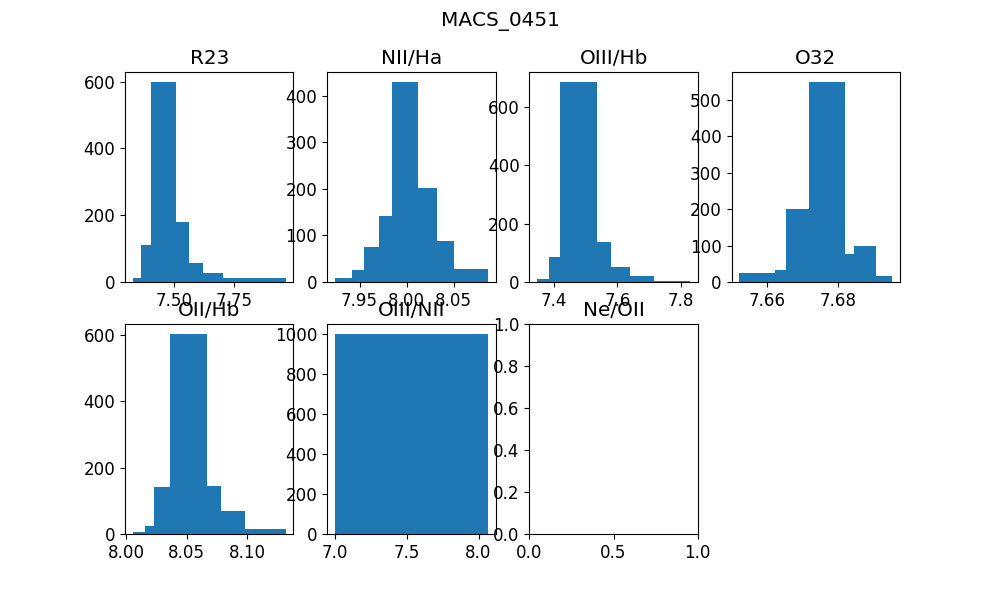

('Nb of R23', 999)
('Nb of O3', 995)
('Nb of O2', 1000)
Ne_OII not available


<IPython.core.display.Javascript object>


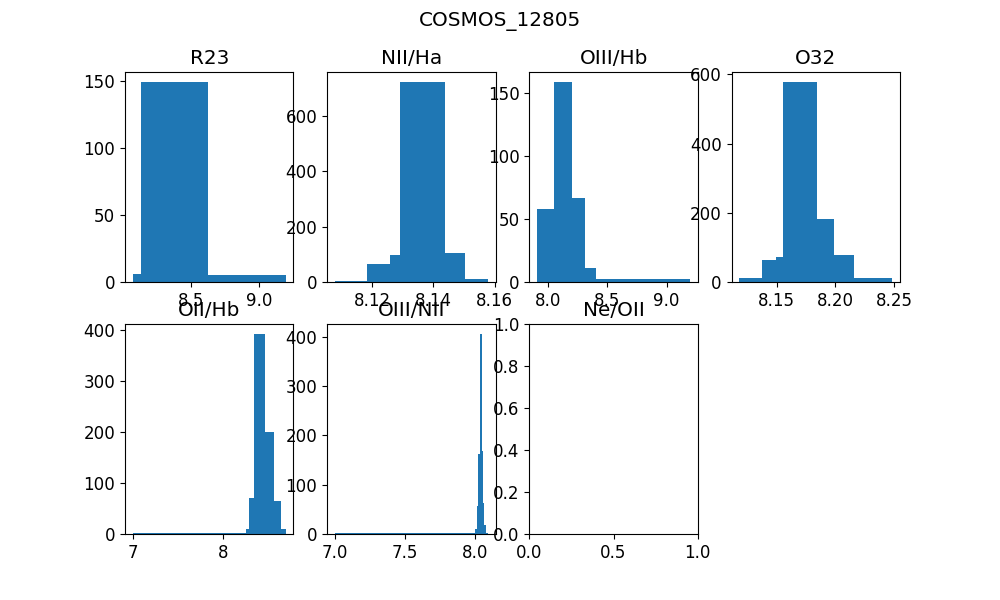

('Nb of R23', 160)
('Nb of O3', 297)
('Nb of O2', 748)
Ne_OII not available


<IPython.core.display.Javascript object>


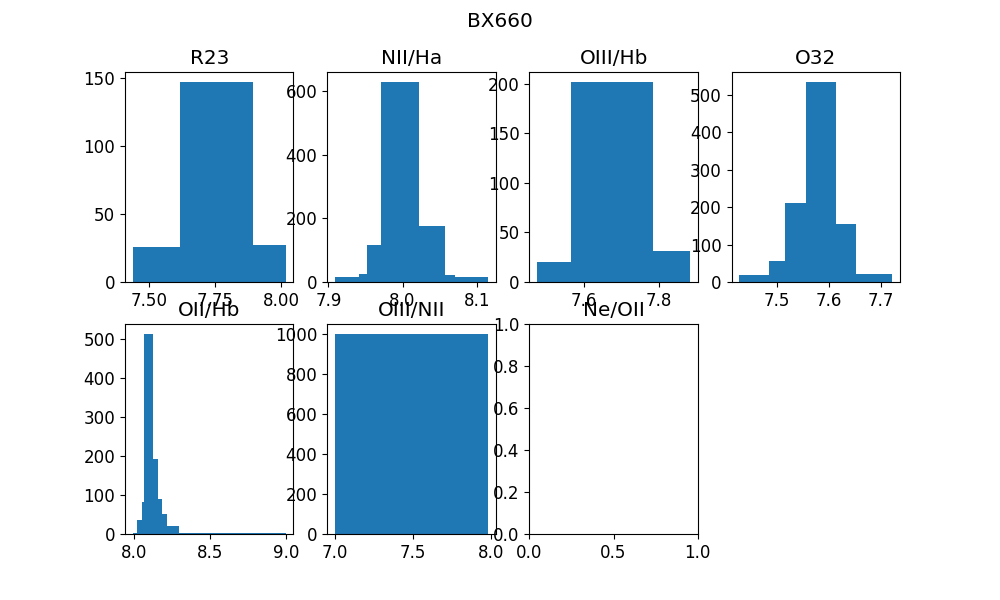

('Nb of R23', 200)
('Nb of O3', 253)
('Nb of O2', 1000)
Ne_OII not available


<IPython.core.display.Javascript object>


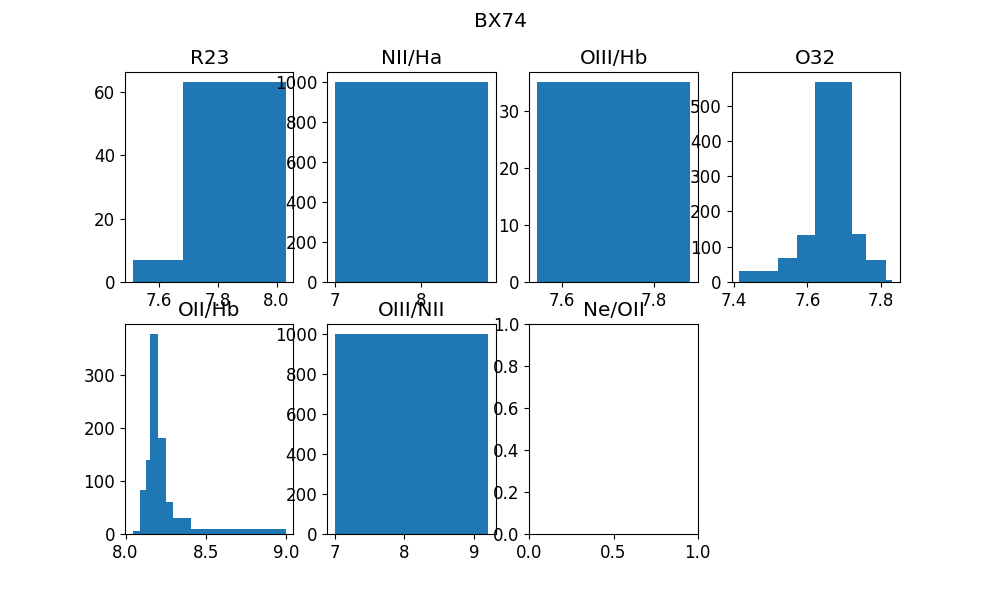

('Nb of R23', 70)
('Nb of O3', 35)
('Nb of O2', 1000)
Ne_OII not available


<IPython.core.display.Javascript object>


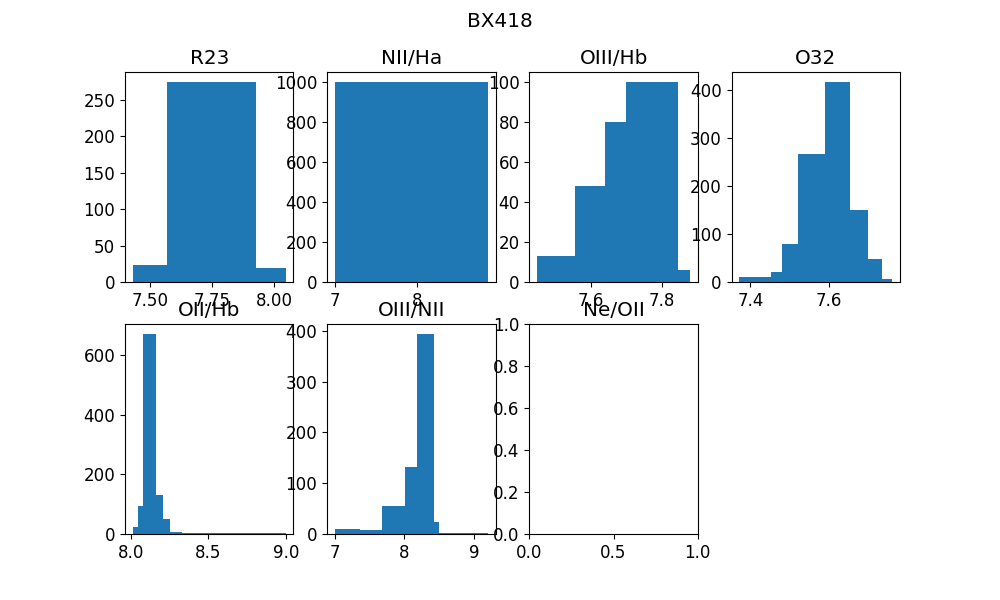

('Nb of R23', 316)
('Nb of O3', 247)
('Nb of O2', 999)
Ne_OII not available


<IPython.core.display.Javascript object>


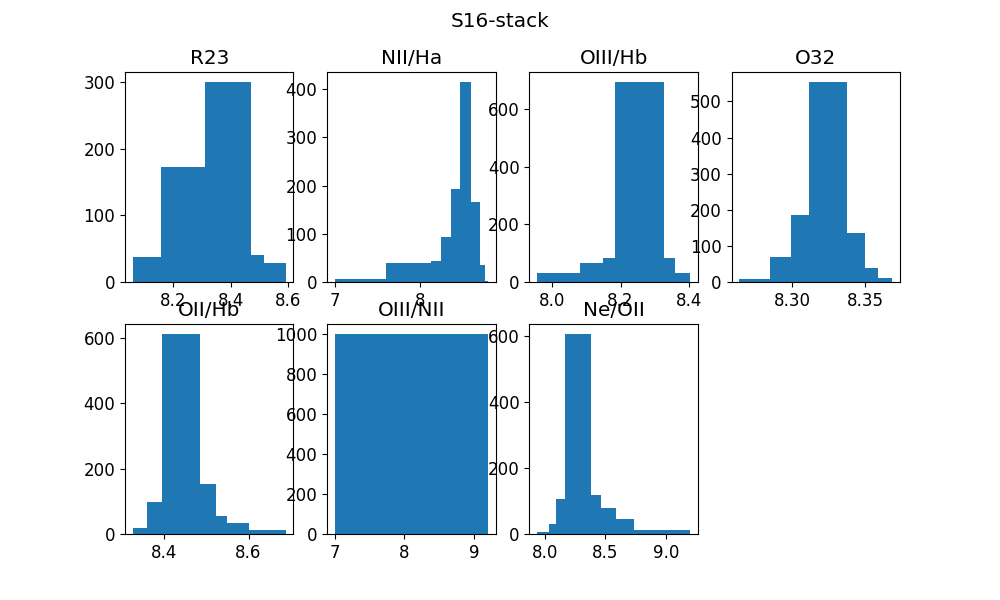

('Nb of R23', 580)
('Nb of O3', 987)
('Nb of O2', 984)


<IPython.core.display.Javascript object>


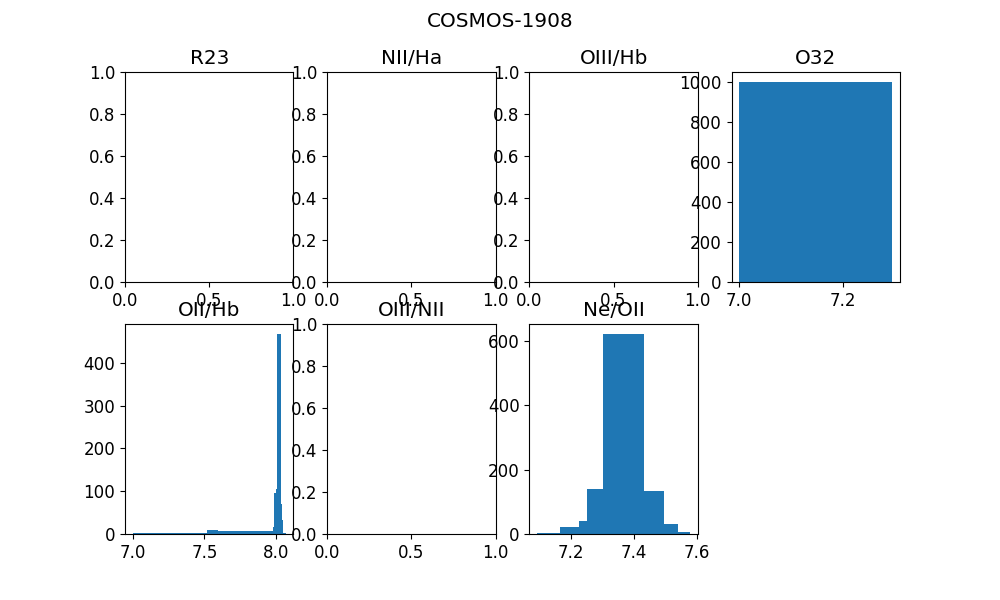

('Nb of R23', 0)
R23 not available for COSMOS-1908
NII_Ha not available
('Nb of O3', 0)
OIII_Hb not available
('Nb of O2', 1000)
OIII_NII not available


<IPython.core.display.Javascript object>


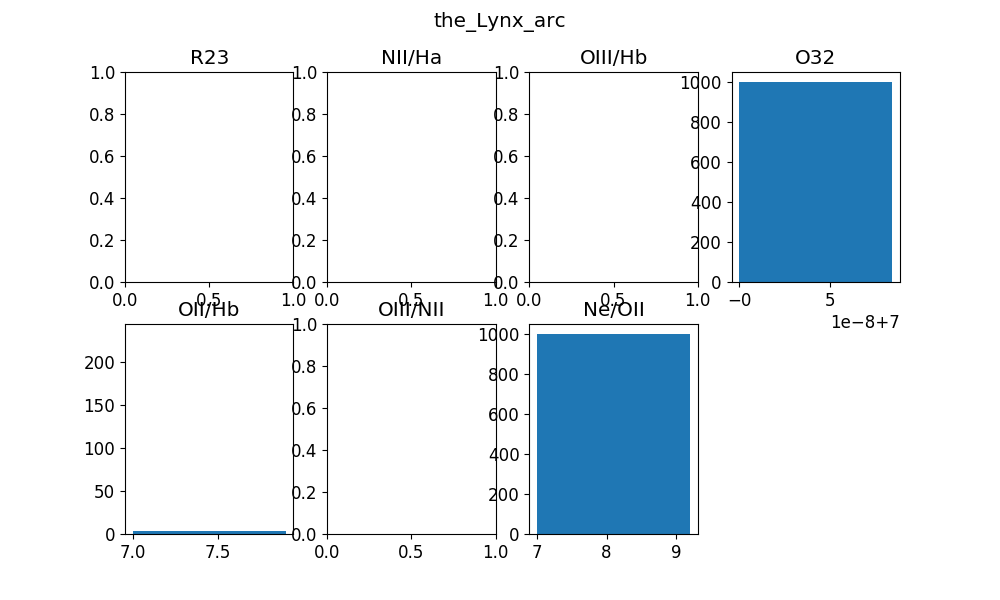

('Nb of R23', 0)
R23 not available for the_Lynx_arc
NII_Ha not available
('Nb of O3', 0)
OIII_Hb not available
('Nb of O2', 1000)
OIII_NII not available


<IPython.core.display.Javascript object>


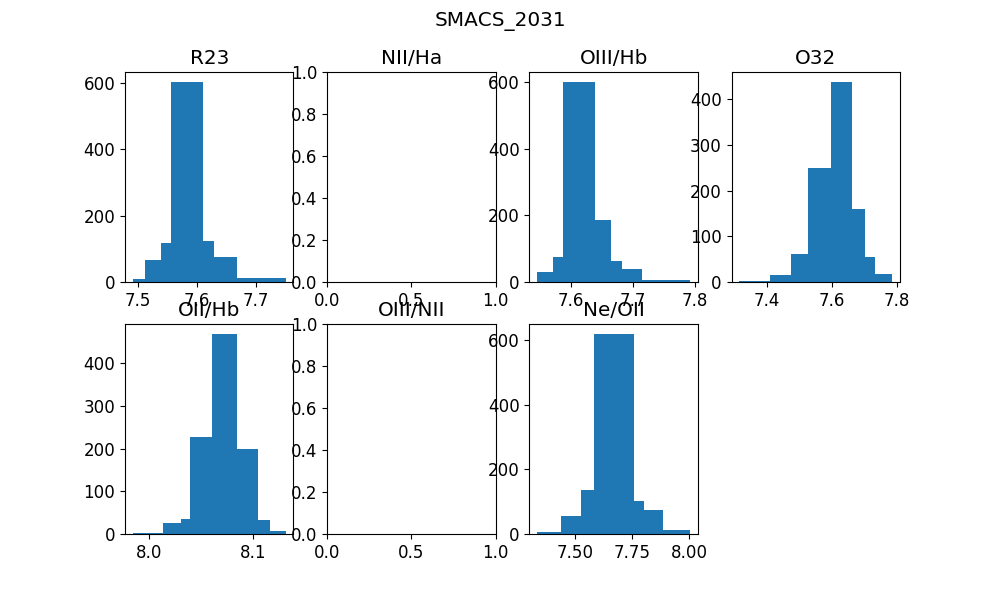

('Nb of R23', 1000)
NII_Ha not available
('Nb of O3', 1000)
('Nb of O2', 1000)
OIII_NII not available


<IPython.core.display.Javascript object>


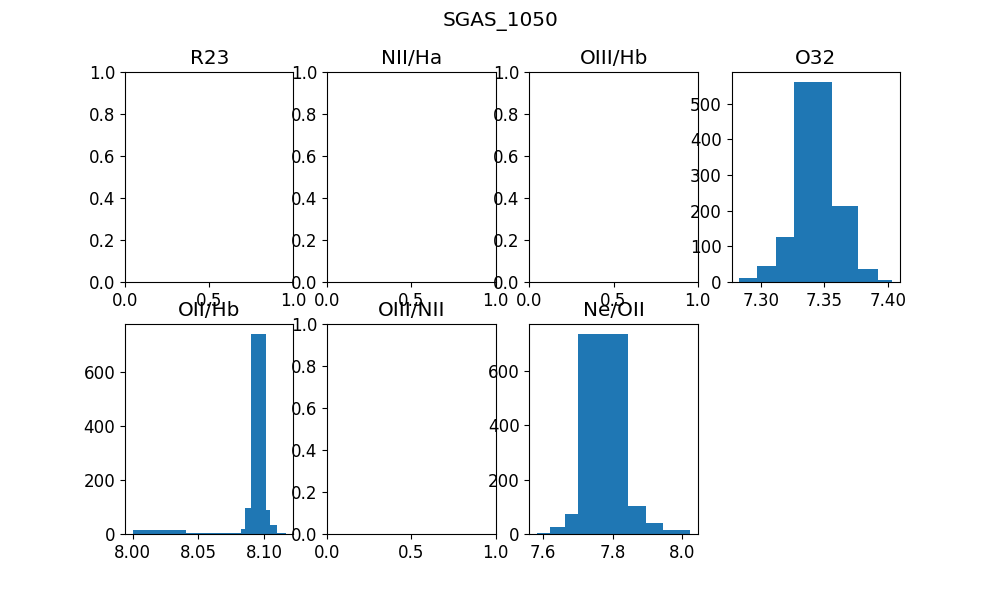

('Nb of R23', 0)
R23 not available for SGAS_1050
NII_Ha not available
('Nb of O3', 0)
OIII_Hb not available
('Nb of O2', 1000)
OIII_NII not available


In [8]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')
gal = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
gal.add_index('Name')

# Maximum ratio values
R23_max = 10**0.9377
O3_max = 10**0.7460
O2_max = 10**0.5606

#Initialise table to save results
maiolino08 = Table(names=['Name','R23','NII_Ha','OIII_Hb','O32','OII_Hb','OIII_NII','Ne_OII',
                                'upR23','upNII_Ha','upOIII_Hb','upO32','upOII_Hb','upOIII_NII','upNe_OII',
                                'lowR23','lowNII_Ha','lowOIII_Hb','lowO32','lowOII_Hb','lowOIII_NII','lowNe_OII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4', 'f4','f4', 'f4','f4','f4','f4', 'f4','f4', 'f4',
                                'f4', 'f4','f4','f4','f4', 'f4','f4',))

MC_steps = 1000

for f_init in dered_fluxes:
    
    R23_sample = []
    NII_Ha_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    OIII_NII_sample =[]
    Ne_OII_sample = []

    for i in range(MC_steps):
        
        init_met = np.random.uniform(low=7.0,high=9.0)
        O32_met = np.nan
        f = perturbed_lines(f_init)   
        
        params = Parameters()
        params.add('met',value=init_met, min=7.0, max=9.2)
        
        # Non degenerate diagnostics
        
        ## NII/Ha
        R = f['NII6584']/f['Ha']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.0, max=9.2)
            fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Maiolino2008))
            NII_Ha_sample.append(fit.params['met'].value)

        ## OIII/NII
        R = f['OIII5007']/f['NII6584']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Maiolino2008))
            OIII_NII_sample.append(fit.params['met'].value)
            
            
        ## Ne/OII
        R = f['NeIII3869']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Maiolino2008))
            Ne_OII_sample.append(fit.params['met'].value)
        
        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R) :
            params['met'].set(value=init_met, min=7.0, max=9.2)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Maiolino2008))
            O32_sample.append(fit.params['met'].value)
            O32_met = fit.params['met'].value
        
        # Degenerate diagnostics
        if np.isnan(O32_met):
            continue
        
        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R) and R < R23_max:
            params['met'].set(value=O32_met , min=7.0, max=9.2)
            fit = minimize(minimise_func, params,args=(R,R23_Maiolino2008))
            R23_sample.append(fit.params['met'].value)

        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R) and R < O3_max:
            params['met'].set(value=O32_met , min=7.0, max=9.2)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Maiolino2008))
            OIII_Hb_sample.append(fit.params['met'].value)            


        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R) and R < O2_max: 
            params['met'].set(value=O32_met , min=7.0, max=9.0)
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Maiolino2008))
            OII_Hb_sample.append(fit.params['met'].value)     
                        
    # Some plots
    fig, ax = plt.subplots(2,4,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        print('Nb of R23',len(R23_sample))
        hist(R23_sample,      bins='blocks',ax=ax[0])        
    except (ValueError,IndexError):
        print('R23 not available for %s'%f_init['Name'])
    try:
        hist(NII_Ha_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('NII_Ha not available')   
    try:
        print('Nb of O3',len(OIII_Hb_sample))
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        print('Nb of O2',len(OII_Hb_sample))
        hist(OII_Hb_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('OII_Hb not available') 
    try:
        hist(OIII_NII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('OIII_NII not available') 
    try:
        hist(Ne_OII_sample,   bins='blocks',ax=ax[6]) 
    except (ValueError,IndexError):
        print('Ne_OII not available') 
        
    ax[0].set_title('R23')
    ax[1].set_title('NII/Ha')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('OII/Hb')
    ax[5].set_title('OIII/NII')
    ax[6].set_title('Ne/OII')
    ax[7].axis('off')    
    
    # Save to table
    maiolino08.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,84)-np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,84)-np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,84)-np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(NII_Ha_sample,50)-np.nanpercentile(NII_Ha_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(OIII_NII_sample,50)-np.nanpercentile(OIII_NII_sample,16),
        np.nanpercentile(Ne_OII_sample,50)-np.nanpercentile(Ne_OII_sample,16)))
                    
maiolino08.write('Metallicity_Maiolino08_init_O32.dat',format='ascii.fixed_width_two_line')

## Plot 

<IPython.core.display.Javascript object>


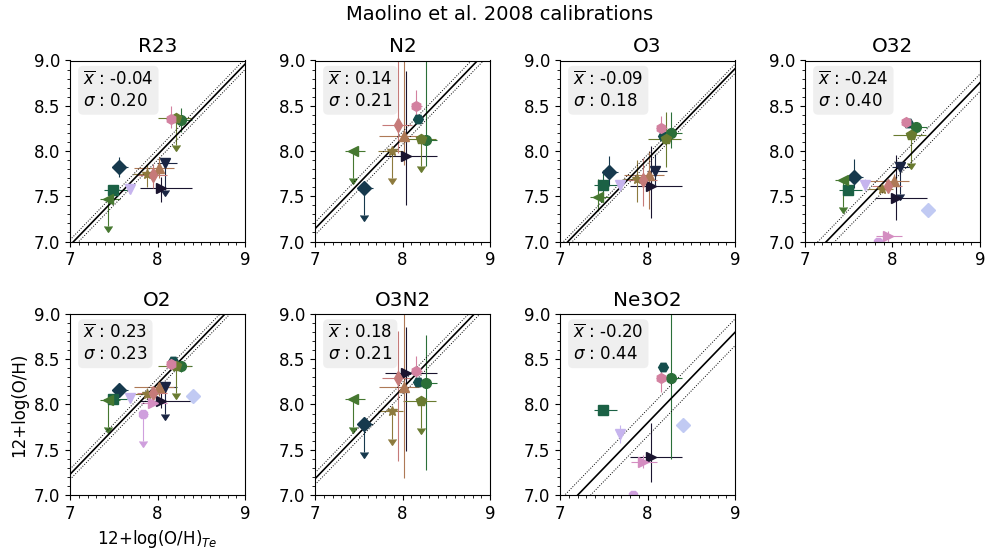

In [9]:
## V1 Compare with direct method and calculate spread
direct_Te = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
maiolino08 = Table.read('Metallicity_Maiolino08_init_O32.dat',format='ascii.fixed_width_two_line')
maiolino08.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Fig
fig, ax = plt.subplots(2,4,figsize=(10,5.5))
fig.suptitle('Maolino et al. 2008 calibrations',fontsize=14,y=0.99)
ax = ax.ravel()
fig.subplots_adjust(top=0.89,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

diff = []
weights = []

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    nb = s.loc[gal['Name']]['nb'] + 1
    
    met = maiolino08.loc[gal['Name']]
    
    # R23
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
         ax[0].errorbar(gal['met'],met['R23'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[0].errorbar(gal['met'],met['R23'],
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr = np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8)

    # N2
    if gal['Name'] in ['Abell_22.3','MACS_0451','COSMOS_12805','BX660']:
        ax[1].errorbar(gal['met'],met['NII_Ha'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((0.3,0.3)).reshape(2,1),
                       uplims = True ,capthick = 0.8,
                       color=c,marker=m,markersize=7,elinewidth=0.8)
    else:
        ax[1].errorbar(gal['met'],met['NII_Ha'], 
               xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
               yerr=np.array((met['upNII_Ha'],met['lowNII_Ha'])).reshape(2,1),
               color=c,marker=m,markersize=7,elinewidth=0.8)

    # O3
    ax[2].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb']+gal['lowmet'],met['lowOIII_Hb']+gal['upmet'])).reshape(2,1),
                   color=c,marker=m,markersize=7,elinewidth=0.8) 
     
    # O32  
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[3].errorbar(gal['met'],met['O32'],  
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,    
                   color=c,marker=m,markersize=7,elinewidth=0.8)   
    else:
        ax[3].errorbar(gal['met'],met['O32'],  
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8)   

    # O2
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[4].errorbar(gal['met'],met['OII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.73)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[4].errorbar(gal['met'],met['OII_Hb'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 

    # O3N2
    if gal['Name'] in ['Abell_22.3','MACS_0451','COSMOS_12805','BX660']:
        ax[5].errorbar(gal['met'],met['OIII_NII'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   marker=m,color=c,markersize=7,elinewidth=0.8)     
    else:
        ax[5].errorbar(gal['met'],met['OIII_NII'],
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upOIII_NII'],met['lowOIII_NII'])).reshape(2,1),
                       marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    # Ne3O2
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[6].errorbar(gal['met'],met['Ne_OII'], 
               xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
               yerr=np.array((0.3,0.3)).reshape(2,1),
               uplims = True ,capthick = 0.8,
            color=c,marker=m,markersize=7,elinewidth=0.8) 
    else:
        ax[6].errorbar(gal['met'],met['Ne_OII'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upNe_OII'],met['lowNe_OII'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 
    
    # Save results
    diff.append((met['R23']-gal['met'],
                 met['NII_Ha']-gal['met'],
                 met['OIII_Hb']-gal['met'],
                 met['O32']-gal['met'],
                 met['OII_Hb']-gal['met'],
                 met['OIII_NII']-gal['met'],
                 met['Ne_OII']-gal['met']))
    
# fix data format
diff = np.array(diff).T
stats = []

# calculate the rms and std
for i in range(7):
    
    # statistics
    data = diff[i][~np.isnan(diff[i])]
    mean = np.mean(data)
    mean_std = bootstrap(data,500,'mean')
    std = np.std(data) 
    std_std = bootstrap(data,500,'std')   
    mae = mean_absolute_error(np.zeros_like(data),data)
    mae_std = bootstrap(data,500,'mae')
    stats.append((mean,mean_std,std,std_std,mae,mae_std))
    
    #plotting
    #ax[i].annotate('$\overline{x}$ : %0.2f$\pm$%0.2f\n$\sigma$ : %0.2f$\pm$%0.2f'%(mean,mean_std,std,std_std),
    ax[i].annotate('$\overline{x}$ : %0.2f\n$\sigma$ : %0.2f'%(mean,std),
                   xy=(7.15,8.5),bbox=dict(boxstyle="round",alpha=0.2,fc="0.7",ec="none"))    
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean,linewidth=1.2,color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean+mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean-mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].set_ylim(7.,9.)
    ax[i].set_xlim(7.,9.)
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))   
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))    

# Set titles
ax[0].set_title('R23')
ax[1].set_title('N2')
ax[2].set_title('O3')
ax[3].set_title('O32')
ax[4].set_title('O2')
ax[5].set_title('O3N2')
ax[6].set_title('Ne3O2')
ax[7].axis('off')
ax[4].set_xlabel('12+log(O/H)$_{Te}$')
ax[4].set_ylabel('12+log(O/H)')

plt.savefig('/Users/vera/Desktop/maiolino.pdf')

In [10]:
## Add to table
o = np.array(stats).T
maiolino08.add_row({'Name':'MEAN','R23':o[0][0],'NII_Ha':o[0][1],'OIII_Hb':o[0][2],'O32':o[0][3],'OII_Hb':o[0][4],
                    'OIII_NII':o[0][5],'Ne_OII':o[0][6],
                   'upR23':o[1][0],'upNII_Ha':o[1][1],'upOIII_Hb':o[1][2],'upO32':o[1][3],'upOII_Hb':o[1][4],
                    'upOIII_NII':o[1][5],'upNe_OII':o[1][6]})
                   
maiolino08.add_row({'Name':'STD','R23':o[2][0],'NII_Ha':o[2][1],'OIII_Hb':o[2][2],'O32':o[2][3],'OII_Hb':o[2][4],
                    'OIII_NII':o[2][5],'Ne_OII':o[2][6],
                   'upR23':o[3][0],'upNII_Ha':o[3][1],'upOIII_Hb':o[3][2],'upO32':o[3][3],'upOII_Hb':o[3][4],
                    'upOIII_NII':o[3][5],'upNe_OII':o[3][6]})

maiolino08.add_row({'Name':'MAE','R23':o[4][0],'NII_Ha':o[4][1],'OIII_Hb':o[4][2],'O32':o[4][3],'OII_Hb':o[4][4],
                    'OIII_NII':o[4][5],'Ne_OII':o[4][6],
                   'upR23':o[5][0],'upNII_Ha':o[5][1],'upOIII_Hb':o[5][2],'upO32':o[5][3],'upOII_Hb':o[5][4],
                    'upOIII_NII':o[5][5],'upNe_OII':o[5][6]})
    
maiolino08.write('Metallicity_Maiolino08_init_O32.dat',format='ascii.fixed_width_two_line')

## Curti 2017

https://arxiv.org/pdf/1610.06939.pdf

Available diagnostics
- R2 = [O II] λ3727/Hβ
- R3 = [O III] λ5007/Hβ
- O32 = [O III] λ5007/[O II] λ3727
- R23 = ([O III] λ4959,5007 + [O II] λ3727)/Hβ
- N2 = [N II] λ6583/Hα
- O3N2 = R3/N2

In [11]:
## Curti 2016 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def OII_3727_Hb_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.3. Error 0.26.
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O II] λ3727 / H beta
    """
    c0,c1,c2,c3 =  0.418, -0.961, -3.505, -1.949
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def OIII_5007_Hb_Curti17(met):
    """ From Curti+16. Range 8.3 < 12+log(O/H) < 8.85. Error 0.07
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007 / Hbeta
    """
    c0,c1,c2,c3 = -0.277, -3.549, -3.593, -0.981        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def R23_Curti17(met):
    """ From Curti+16. Range  8.4 < 12+log(O/H) < 8.85. Error 0.12
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        ([O III] λ4959,5007 + [O II] λ3727)/Hβ
    """
    c0,c1,c2,c3 = 0.527, -1.569, -1.652, -0.421        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def NII_6584_Ha_Curti17(met):
    """ From Curti+16
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [N II] λ6583/Hα
    """
    c0,c1,c2,c3,c4  = -0.489, 1.513, -2.554, -5.293, -2.867     
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))


def OIII_5007_OII_3727_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.10
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007/[O II] λ3727
    """
    c0,c1,c2 = -0.691, -2.944, -1.308       
    return (10**polyval(met-8.69,(c0,c1,c2)))

def OIII_5007_NII_6584_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.09
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        R3/N2
    """
    c0,c1,c2 = 0.281, -4.765, -2.268       
    return (10**polyval(met-8.69,(c0,c1,c2)))

### Calculate maximum ratio values

<IPython.core.display.Javascript object>


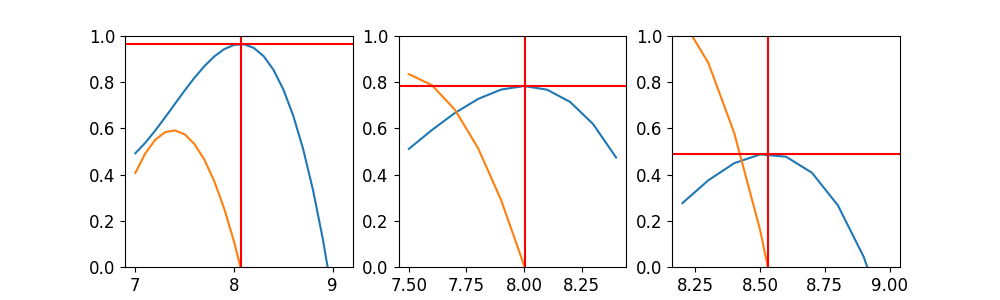

R23 maximum (12+log(O/H),log(R)) = (8.0665,0.9651)
O3 maximum (12+log(O/H),log(R)) = (8.0026,0.7835)
O2 maximum (12+log(O/H),log(R)) = (8.5321,0.4900)


In [12]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

# R23
c0,c1,c2,c3 = 0.527, -1.569, -1.652, -0.421
deriv = P.polyder(c=(c0,c1,c2,c3),m=1)
met = np.arange(7.,9.2,0.1)
ax[0].plot(met,polyval(met-8.69,(c0,c1,c2,c3)))
ax[0].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[1]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3))
ax[0].axvline(np.real(min_point.real),c='r')
ax[0].axhline(ymax,c='r')
ax[0].set_ylim(0,1.)
print('R23 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O3
c0,c1,c2,c3 = -0.277, -3.549, -3.593, -0.981 
deriv = P.polyder(c=(c0,c1,c2,c3),m=1)
met = np.arange(7.5,8.5,0.1)
ax[1].plot(met,polyval(met-8.69,(c0,c1,c2,c3)))
ax[1].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[1]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3))
ax[1].axvline(np.real(min_point.real),c='r')
ax[1].axhline(ymax,c='r')
ax[1].set_ylim(0,1.)
print('O3 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O2
c0,c1,c2,c3 =  0.418, -0.961, -3.505, -1.949
deriv = P.polyder(c=(c0,c1,c2,c3),m=1)
met = np.arange(8.2,9.0,0.1)
ax[2].plot(met,polyval(met-8.69,(c0,c1,c2,c3)))
ax[2].plot(met,polyval(met-8.69,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[1]+8.69
ymax = polyval(np.real(min_point.real)-8.69,(c0,c1,c2,c3))
ax[2].axvline(np.real(min_point.real),c='r')
ax[2].axhline(ymax,c='r')
ax[2].set_ylim(0,1.)
print('O2 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

### Calculate metallicity

<IPython.core.display.Javascript object>


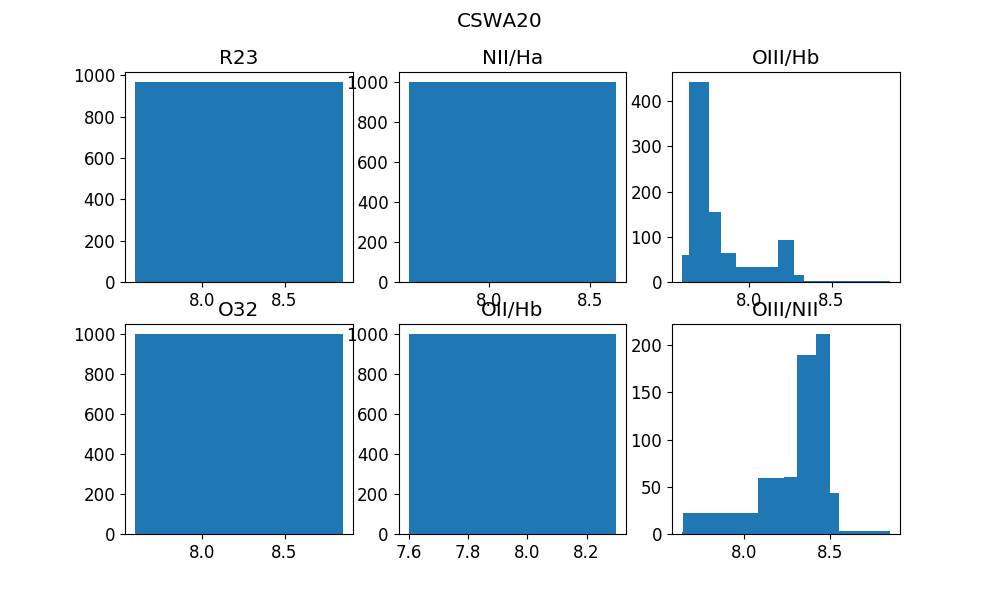

<IPython.core.display.Javascript object>


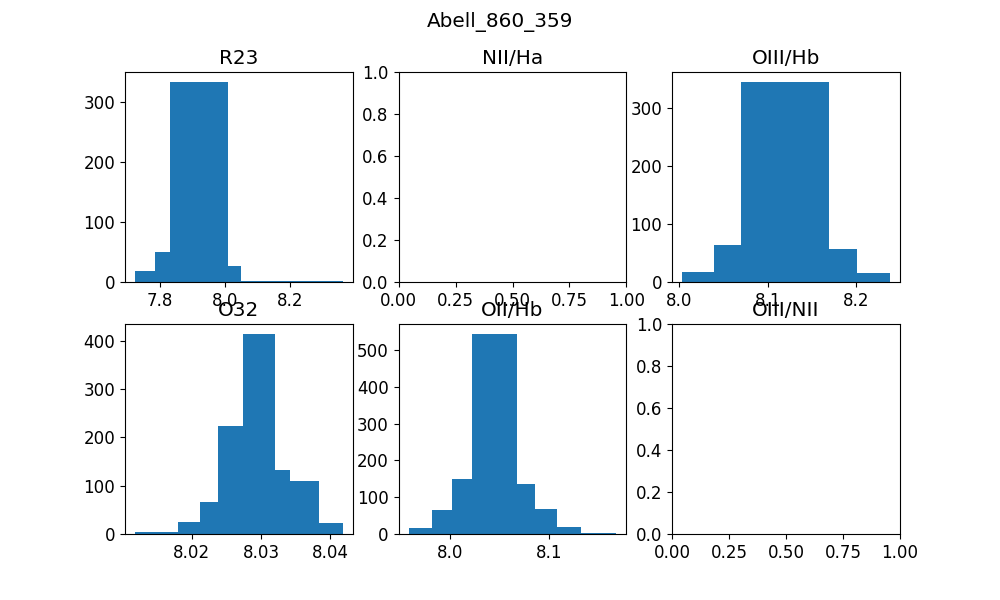

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


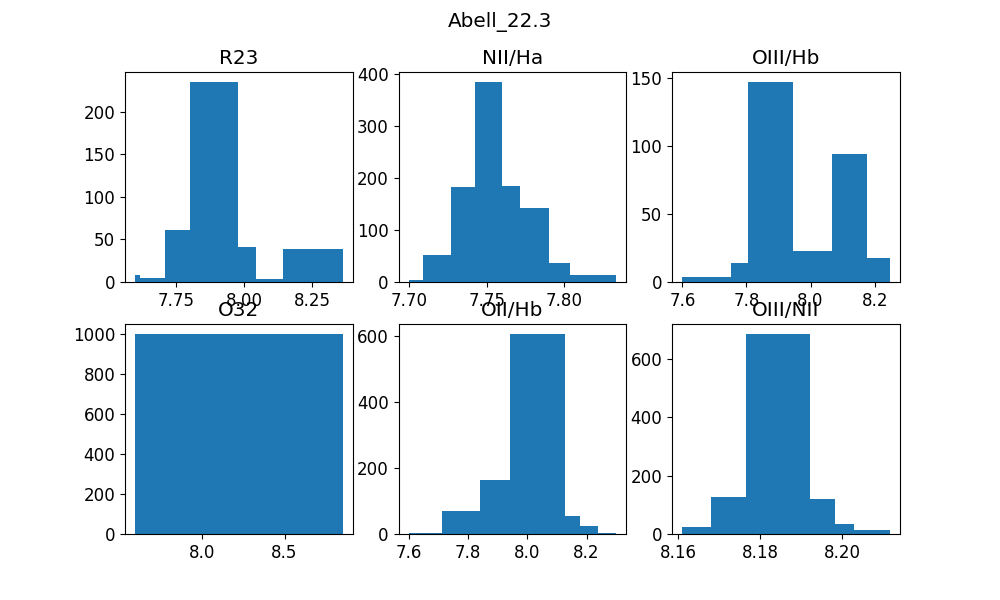

<IPython.core.display.Javascript object>


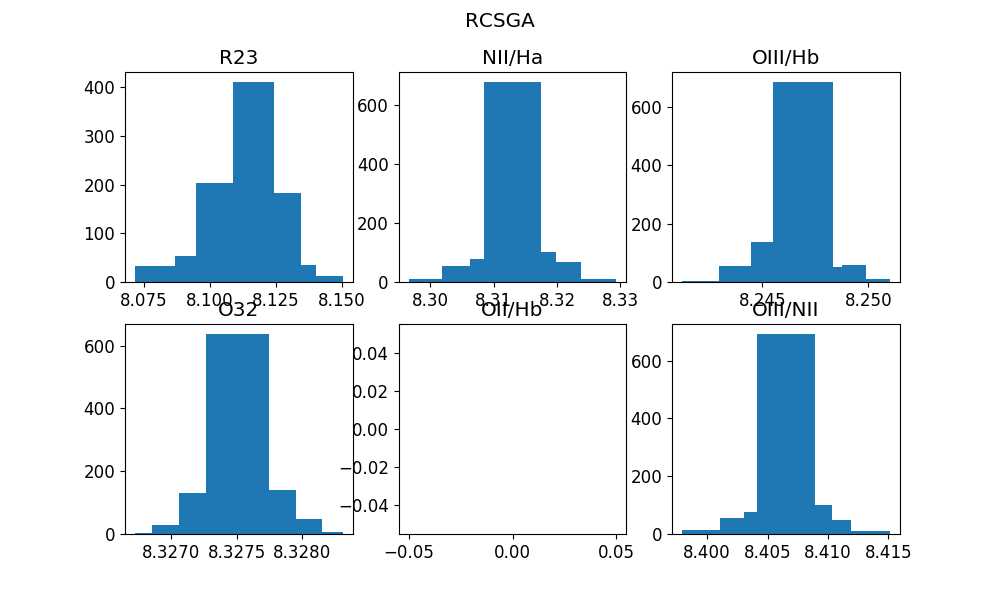

<IPython.core.display.Javascript object>


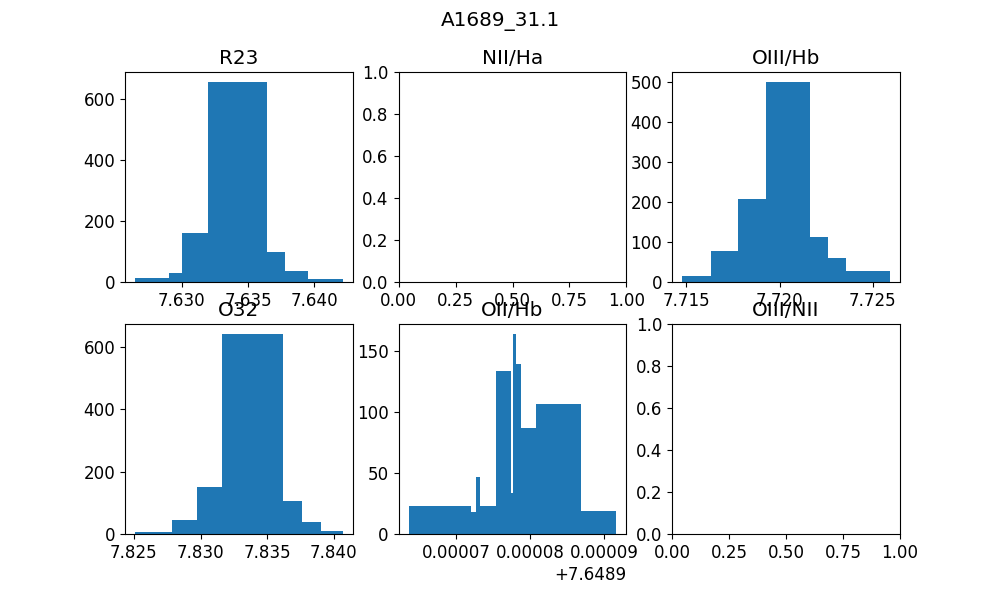

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


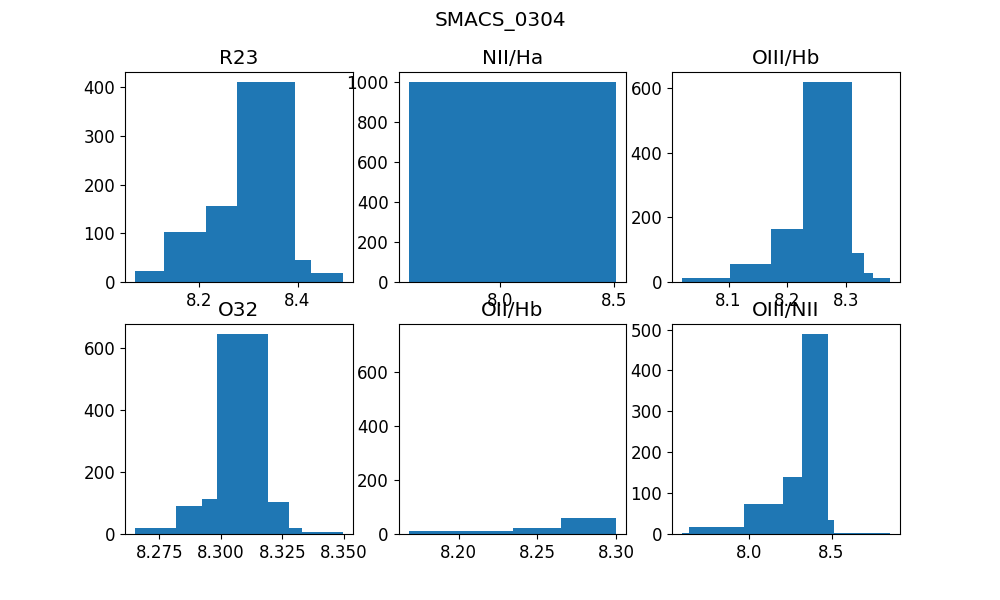

<IPython.core.display.Javascript object>


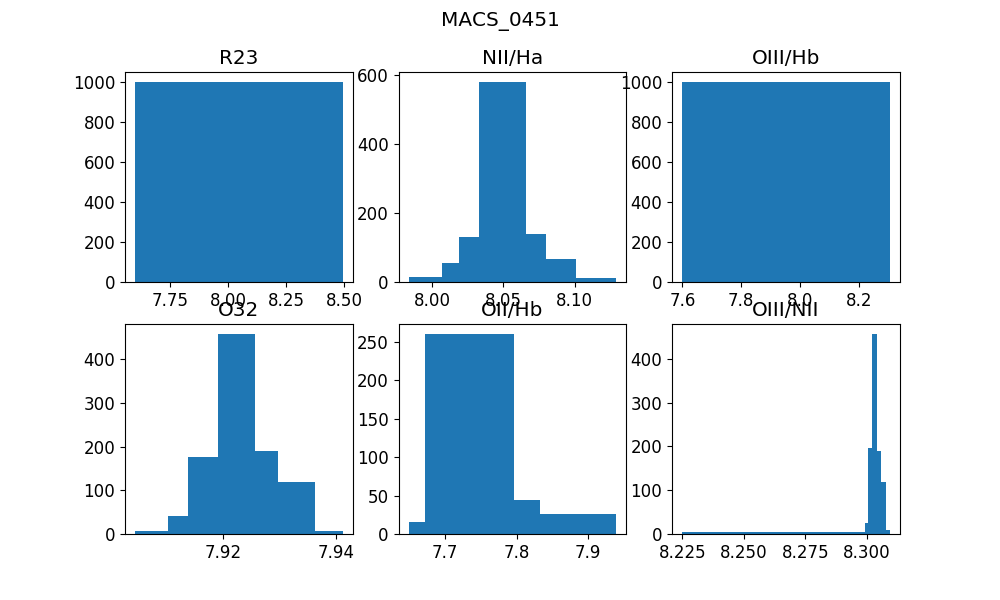

<IPython.core.display.Javascript object>


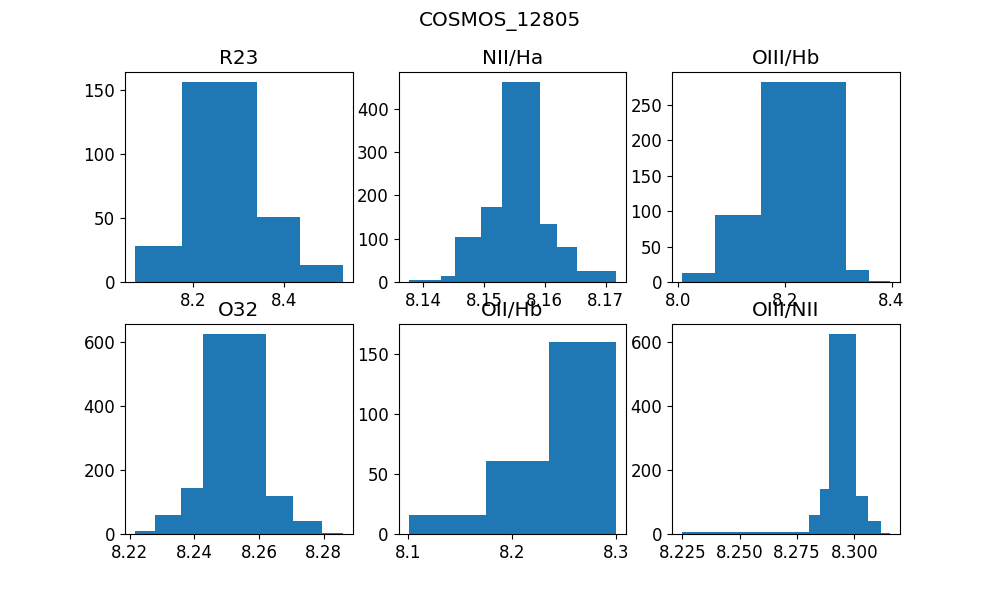

<IPython.core.display.Javascript object>


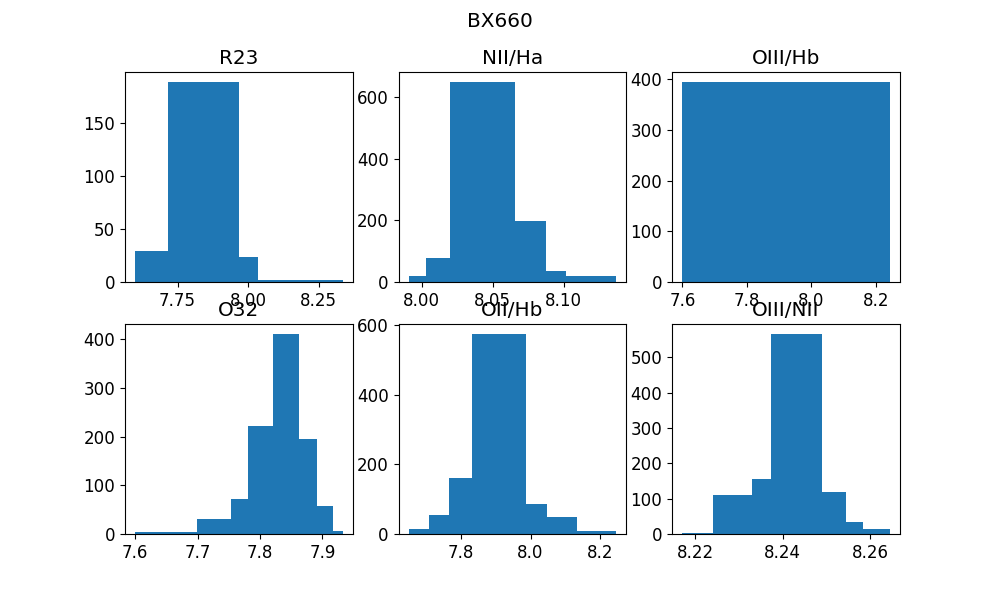

<IPython.core.display.Javascript object>


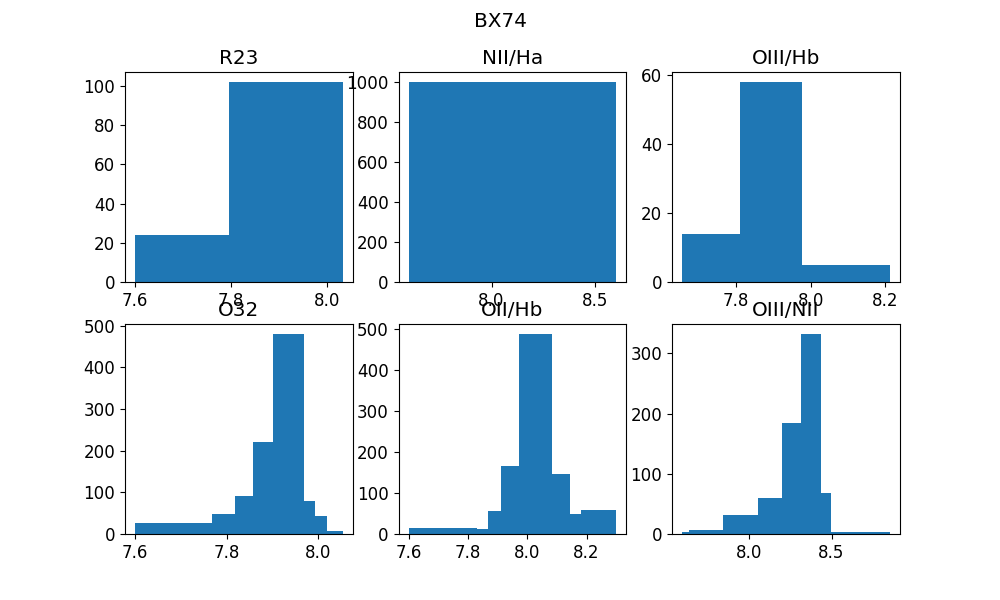

<IPython.core.display.Javascript object>


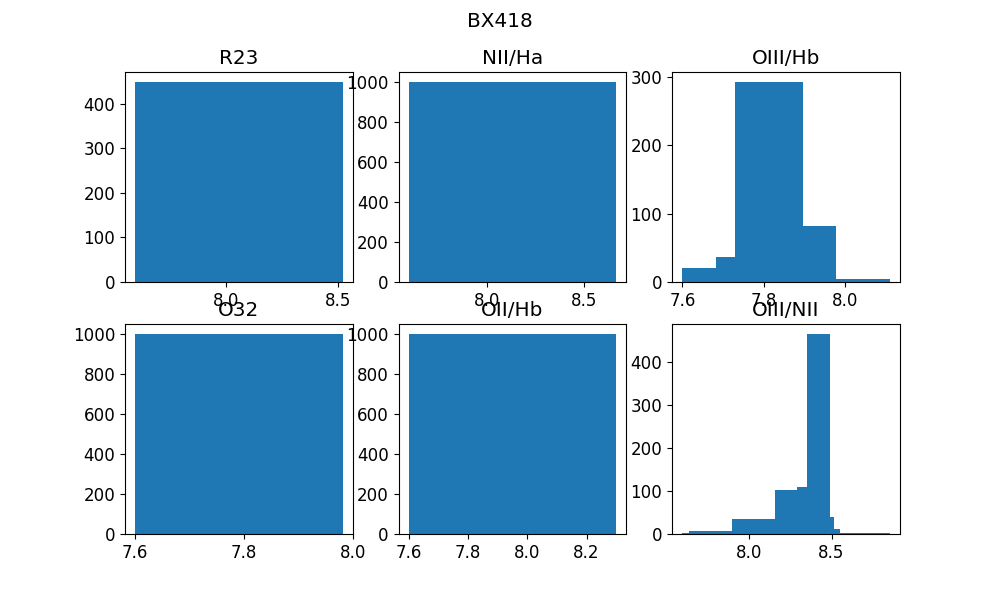

<IPython.core.display.Javascript object>


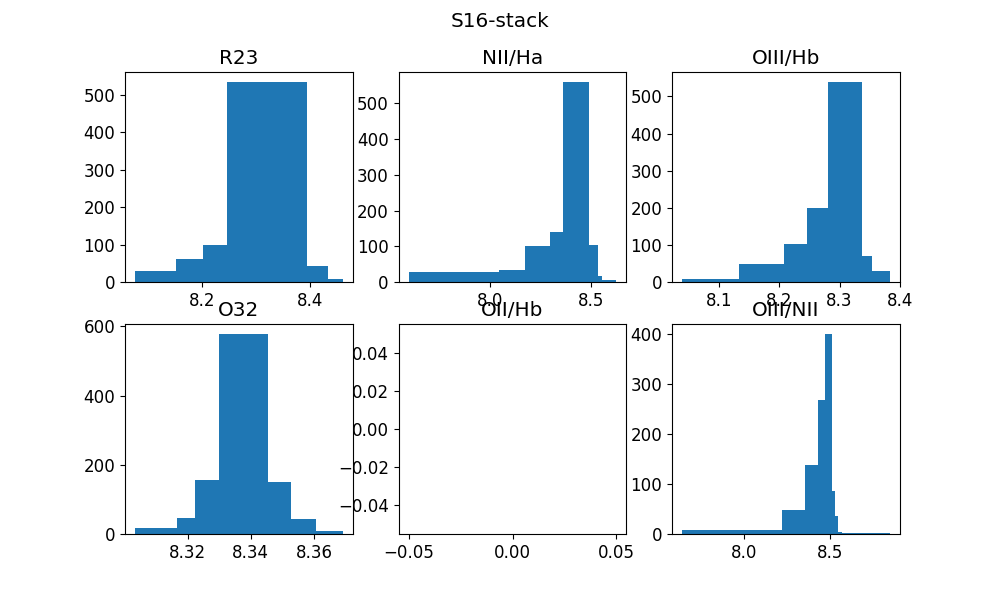

<IPython.core.display.Javascript object>


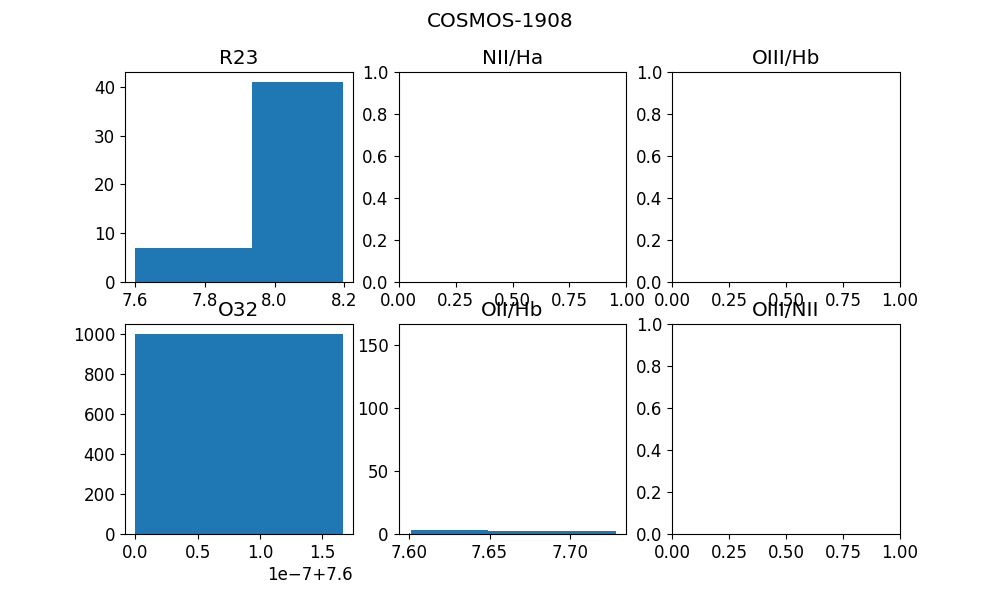

NII_Ha not available
OIII_Hb not available
OIII_NII not available


<IPython.core.display.Javascript object>


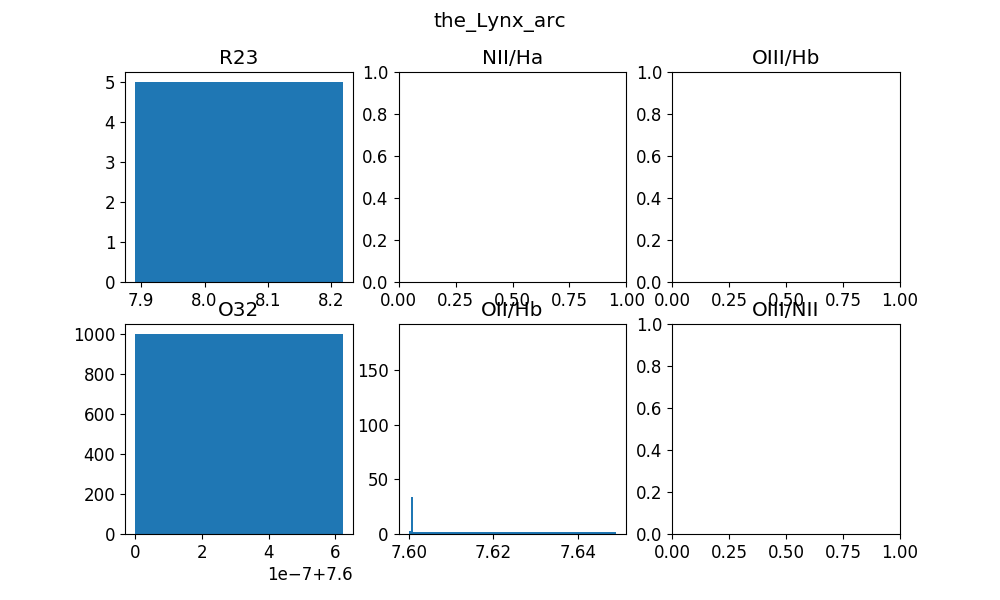

NII_Ha not available
OIII_Hb not available
OIII_NII not available


<IPython.core.display.Javascript object>


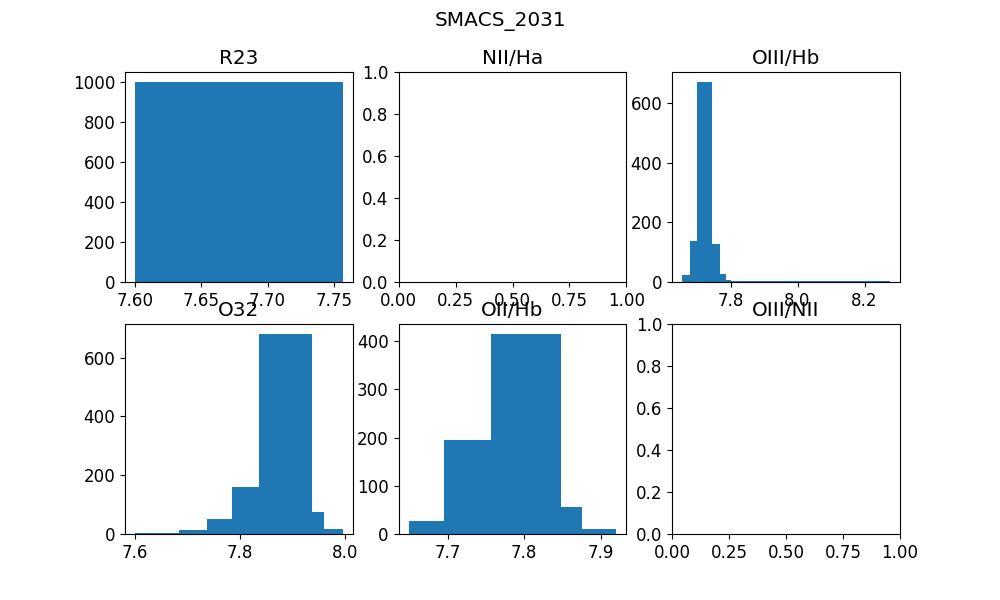

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


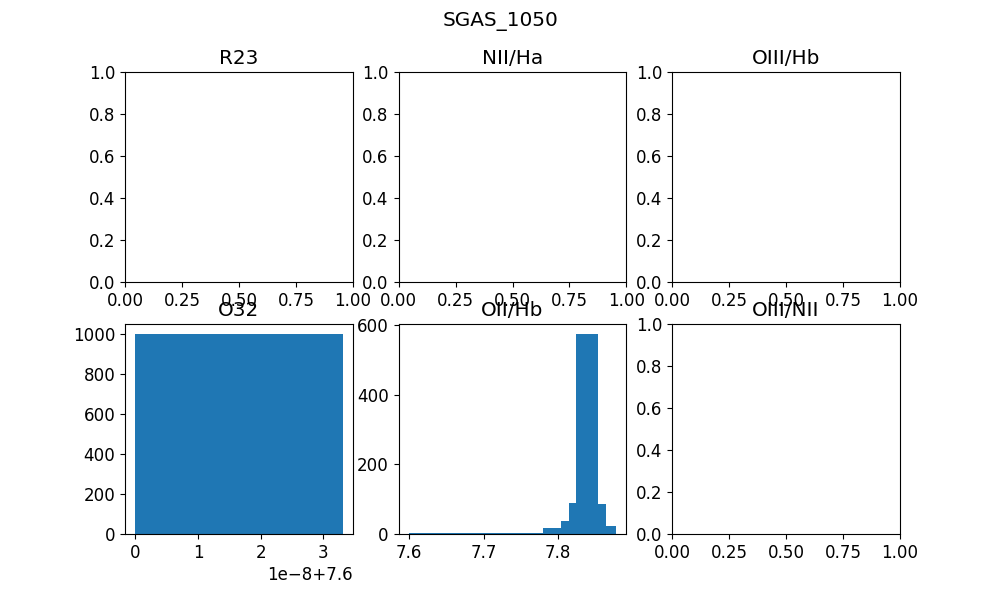

R23 not available
NII_Ha not available
OIII_Hb not available
OIII_NII not available


In [13]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')
gal = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
gal.add_index('Name')

# Maximum ratio value
R23_max = 10**0.9651
O3_max = 10**0.7835
O2_max = 10**0.4900

#Initialise table to save results
curti17 = Table(names=['Name','R23','NII_Ha','OIII_Hb','O32','OII_Hb','OIII_NII',
                                'upR23','upNII_Ha','upOIII_Hb','upO32','upOII_Hb','upOIII_NII',
                                'lowR23','lowNII_Ha','lowOIII_Hb','lowO32','lowOII_Hb','lowOIII_NII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4', 'f4','f4', 'f4','f4','f4','f4', 'f4','f4', 'f4',
                                'f4', 'f4','f4','f4'))

for f_init in dered_fluxes:
    
    R23_sample = []
    NII_Ha_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    OIII_NII_sample =[]

    for i in range(MC_steps):
        
        f = perturbed_lines(f_init)          
        
        # Non degenerate calibrations        
        params = Parameters()
        init_met = np.random.uniform(low=7.6,high=8.85)
        params.add('met', value=init_met, min=7.60, max=8.85) 
        O32_met = np.nan

        ## NII/Ha
        R = f['NII6584']/f['Ha']
        if np.isfinite(R):
            fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Curti17))
            NII_Ha_sample.append(fit.params['met'].value)
        
        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.60, max=8.85)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Curti17))
            O32_sample.append(fit.params['met'].value)
            O32_met = fit.params['met'].value
        
        ## OIII/NII
        R = f['OIII5007']/f['NII6584']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.6, max=8.85)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Curti17))
            OIII_NII_sample.append(fit.params['met'].value)
            
        
        # Degenerate diagnostics
        if np.isnan(O32_met):
            continue
        
        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R) and R < R23_max:
            params['met'].set( value=O32_met, min=7.6, max=8.85) # min should be 8.4
            fit = minimize(minimise_func, params,args=(R,R23_Curti17))
            R23_sample.append(fit.params['met'].value)
       
        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R) and R < O3_max:
            params['met'].set(value=O32_met, min=7.6, max=8.85) # min should be 8.3
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Curti17))
            OIII_Hb_sample.append(fit.params['met'].value) 
  
        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R) and R < O2_max:
            params['met'].set(value=O32_met, min=7.60, max=8.3) 
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Curti17))
            OII_Hb_sample.append(fit.params['met'].value)

                        
    # Some plots
    fig, ax = plt.subplots(2,3,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        hist(R23_sample,      bins='blocks',ax=ax[0]) 
    except (ValueError,IndexError):
        print('R23 not available')
    try:
        hist(NII_Ha_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('NII_Ha not available')   
    try:
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        hist(OII_Hb_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('OII_Hb not available') 
    try:
        hist(OIII_NII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('OIII_NII not available') 
        
    ax[0].set_title('R23')
    ax[1].set_title('NII/Ha')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('OII/Hb')
    ax[5].set_title('OIII/NII')
    
    
    # Save to table
    curti17.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,84)-np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,84)-np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(NII_Ha_sample,50)-np.nanpercentile(NII_Ha_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(OIII_NII_sample,50)-np.nanpercentile(OIII_NII_sample,16)))
                    
curti17.write('Metallicity_Curti17_init_O32.dat',format='ascii.fixed_width_two_line')

## Plot

<IPython.core.display.Javascript object>


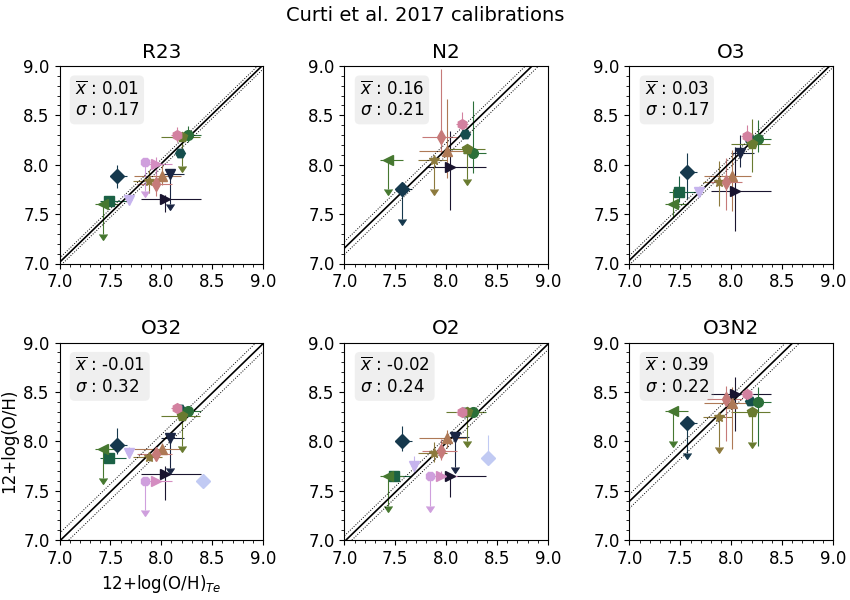

In [14]:
direct_Te = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
curti17 = Table.read('Metallicity_Curti17_init_O32.dat',format='ascii.fixed_width_two_line')
curti17.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Fig
fig, ax = plt.subplots(2,3,figsize=(8.5,6))
fig.subplots_adjust(top=0.89,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
fig.suptitle('Curti et al. 2017 calibrations',fontsize=14,y=0.99)
ax = ax.ravel()
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

diff = []
weights = []

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    nb = s.loc[gal['Name']]['nb'] + 1
    met = curti17.loc[gal['Name']]
    
    # R23
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
         ax[0].errorbar(gal['met'],met['R23'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[0].errorbar(gal['met'],met['R23'],
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr = np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8)

    # N2
    if gal['Name'] in ['Abell_22.3','MACS_0451','COSMOS_12805','BX660']:
        ax[1].errorbar(gal['met'],met['NII_Ha'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((0.3,0.3)).reshape(2,1),
                       uplims = True ,capthick = 0.8,
                       color=c,marker=m,markersize=7,elinewidth=0.8)
    else:
        ax[1].errorbar(gal['met'],met['NII_Ha'], 
               xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
               yerr=np.array((met['upNII_Ha'],met['lowNII_Ha'])).reshape(2,1),
               color=c,marker=m,markersize=7,elinewidth=0.8)

    # O3
    ax[2].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb']+gal['lowmet'],met['lowOIII_Hb']+gal['upmet'])).reshape(2,1),
                   color=c,marker=m,markersize=7,elinewidth=0.8) 
     
    # O32  
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[3].errorbar(gal['met'],met['O32'],  
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,    
                   color=c,marker=m,markersize=7,elinewidth=0.8)   
    else:
        ax[3].errorbar(gal['met'],met['O32'],  
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8)   

    # O2
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[4].errorbar(gal['met'],met['OII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.73)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[4].errorbar(gal['met'],met['OII_Hb'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 

    # O3N2
    if gal['Name'] in ['Abell_22.3','MACS_0451','COSMOS_12805','BX660']:
        ax[5].errorbar(gal['met'],met['OIII_NII'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   marker=m,color=c,markersize=7,elinewidth=0.8)     
    else:
        ax[5].errorbar(gal['met'],met['OIII_NII'],
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upOIII_NII'],met['lowOIII_NII'])).reshape(2,1),
                       marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    # Save results
    diff.append((met['R23']-gal['met'],
                 met['NII_Ha']-gal['met'],
                 met['OIII_Hb']-gal['met'],
                 met['O32']-gal['met'],
                 met['OII_Hb']-gal['met'],
                 met['OIII_NII']-gal['met']))

# fix data format
diff = np.array(diff).T
stats = []


# calculate the rms and std
for i in range(6):
    
    # statistics
    data = diff[i][~np.isnan(diff[i])]
    mean = np.mean(data)
    mean_std = bootstrap(data,500,'mean')
    std = np.std(data) 
    std_std = bootstrap(data,500,'std')   
    mae = mean_absolute_error(np.zeros_like(data),data)
    mae_std = bootstrap(data,500,'mae')
    stats.append((mean,mean_std,std,std_std,mae,mae_std))
    
    #plotting
    ax[i].annotate('$\overline{x}$ : %0.2f\n$\sigma$ : %0.2f'%(mean,std),
                   xy=(7.15,8.5),bbox=dict(boxstyle="round",alpha=0.2,fc="0.7",ec="none"))    
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean,linewidth=1.2,color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean+mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean-mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].set_ylim(7.,9.)
    ax[i].set_xlim(7.,9.)
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))   
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))    
    
# Set titles
ax[0].set_title('R23')
ax[1].set_title('N2')
ax[2].set_title('O3')
ax[3].set_title('O32')
ax[4].set_title('O2')
ax[5].set_title('O3N2')
ax[3].set_xlabel('12+log(O/H)$_{Te}$')
ax[3].set_ylabel('12+log(O/H)')

plt.savefig('/Users/vera/Desktop/curti.pdf')

o = np.array(stats).T
curti17.add_row({'Name':'MEAN','R23':o[0][0],'NII_Ha':o[0][1],'OIII_Hb':o[0][2],'O32':o[0][3],'OII_Hb':o[0][4],
                             'OIII_NII':o[0][5],
                             'upR23':o[1][0],'upNII_Ha':o[1][1],'upOIII_Hb':o[1][2],'upO32':o[1][3],'upOII_Hb':o[1][4],
                            'upOIII_NII':o[1][5]})

curti17.add_row({'Name':'STD','R23':o[2][0],'NII_Ha':o[2][1],'OIII_Hb':o[2][2],'O32':o[2][3],'OII_Hb':o[2][4],
                             'OIII_NII':o[2][5],
                             'upR23':o[3][0],'upNII_Ha':o[3][1],'upOIII_Hb':o[3][2],'upO32':o[3][3],'upOII_Hb':o[3][4],
                            'upOIII_NII':o[3][5]})

curti17.add_row({'Name':'MAE','R23':o[4][0],'NII_Ha':o[4][1],'OIII_Hb':o[4][2],'O32':o[4][3],'OII_Hb':o[4][4],
                             'OIII_NII':o[4][5],
                             'upR23':o[5][0],'upNII_Ha':o[5][1],'upOIII_Hb':o[5][2],'upO32':o[5][3],'upOII_Hb':o[5][4],
                            'upOIII_NII':o[5][5]})

curti17.write('Metallicity_Curti17_init_O32.dat',format='ascii.fixed_width_two_line')

## Jones 2015

In [15]:
## Jones 2015 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def NeIII_3870_OII_3727_Jones15(met):
    """ From Jones+15. Error 0.22.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O ii]
    """
    c0,c1 =  16.8974, -2.1588
    return (10**polyval(met,(c0,c1)))

def OIII_5007_OII_3727_Jones15(met):
    """ From Jones+15. Error 0.23.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/[O ii]
    """
    c0,c1 =  17.9828, -2.1552
    return (10**polyval(met,(c0,c1)))


def NeIII_3870_OIII_5007_Jones15(met):
    """ From Jones+15. Error 0.04.
    This is a VERY BAD diagnostic!
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O iii]
    """
    c0,c1 = -1.0854, -0.0036
    return (10**polyval(met,(c0,c1)))


def OIII_5007_Hb_Jones15(met):
    """ From Jones+15. Error 0.10.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/H beta
    """
    c0,c1,c2 = -88.4378, 22.7529, -1.4501
    return (10**polyval(met,(c0,c1,c2)))


def OII_3727_Hb_Jones15(met):
    """ From Jones+15. Error 0.15.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O ii] / Hbeta
    """
    c0,c1,c2 = -154.9571, 36.9128, -2.1921
    return (10**polyval(met,(c0,c1,c2)))


def R23_Jones15(met):
    """ From Jones+15. Error 0.06.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
       R23
    """
    c0,c1,c2 = -54.1003, 13.9083, -0.8782
    return (10**polyval(met,(c0,c1,c2)))

### Calculate maximum ratio values 

<IPython.core.display.Javascript object>


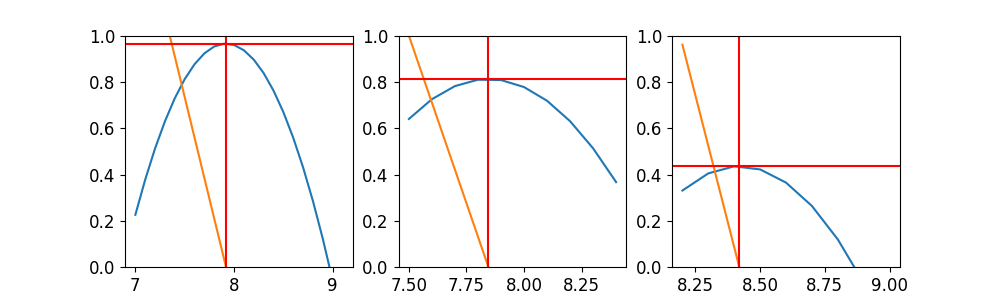

R23 maximum (12+log(O/H),log(R)) = (7.9186,0.9671)
O3 maximum (12+log(O/H),log(R)) = (7.8453,0.8137)
O2 maximum (12+log(O/H),log(R)) = (8.4195,0.4367)


In [16]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

# R23
c0,c1,c2 = -54.1003, 13.9083, -0.8782
deriv = P.polyder(c=(c0,c1,c2),m=1)
met = np.arange(7.,9.2,0.1)
ax[0].plot(met,polyval(met,(c0,c1,c2)))
ax[0].plot(met,polyval(met,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[0]
ymax = polyval(np.real(min_point.real),(c0,c1,c2))
ax[0].axvline(np.real(min_point.real),c='r')
ax[0].axhline(ymax,c='r')
ax[0].set_ylim(0,1.)
print('R23 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O3
c0,c1,c2 = -88.4378, 22.7529, -1.4501
deriv = P.polyder(c=(c0,c1,c2),m=1)
met = np.arange(7.5,8.5,0.1)
ax[1].plot(met,polyval(met,(c0,c1,c2)))
ax[1].plot(met,polyval(met,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[0]
ymax = polyval(np.real(min_point.real),(c0,c1,c2))
ax[1].axvline(np.real(min_point.real),c='r')
ax[1].axhline(ymax,c='r')
ax[1].set_ylim(0,1.)
print('O3 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

# O2
c0,c1,c2 = -154.9571, 36.9128, -2.1921
deriv = P.polyder(c=(c0,c1,c2),m=1)
met = np.arange(8.2,9.0,0.1)
ax[2].plot(met,polyval(met,(c0,c1,c2)))
ax[2].plot(met,polyval(met,(deriv)),color='C1')
min_point =  poly.polyroots(deriv)[0]
ymax = polyval(np.real(min_point.real),(c0,c1,c2))
ax[2].axvline(np.real(min_point.real),c='r')
ax[2].axhline(ymax,c='r')
ax[2].set_ylim(0,1.)
print('O2 maximum (12+log(O/H),log(R)) = (%0.4f,%0.4f)'%(np.real(min_point.real),ymax))

### Calculate metallicities

<IPython.core.display.Javascript object>


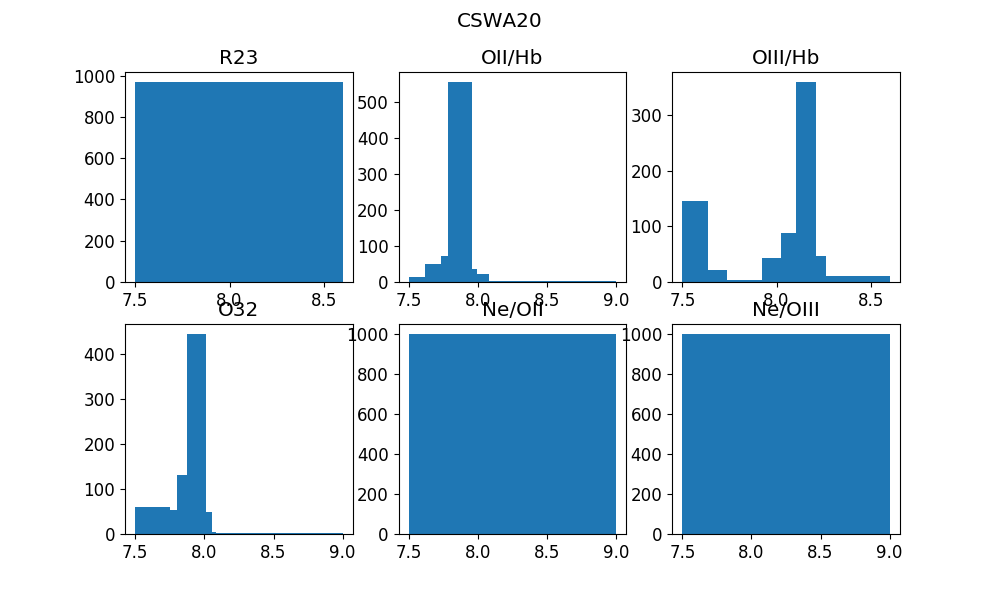

<IPython.core.display.Javascript object>


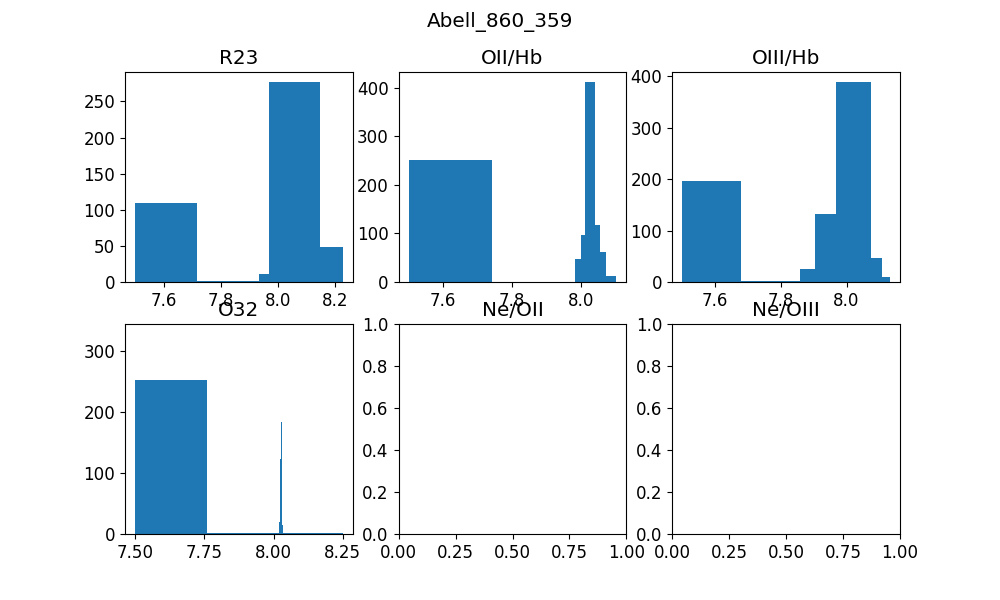

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


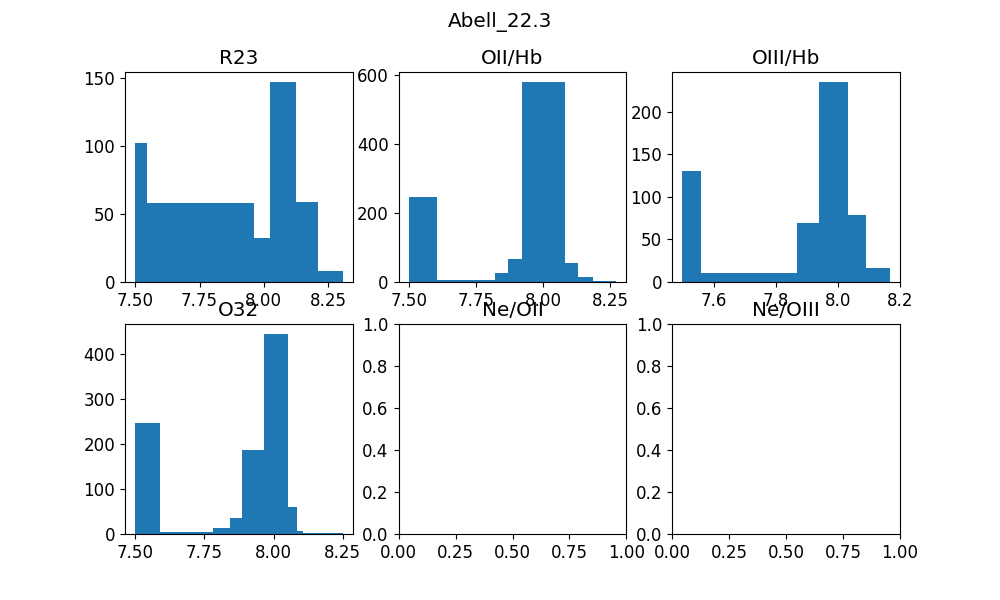

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


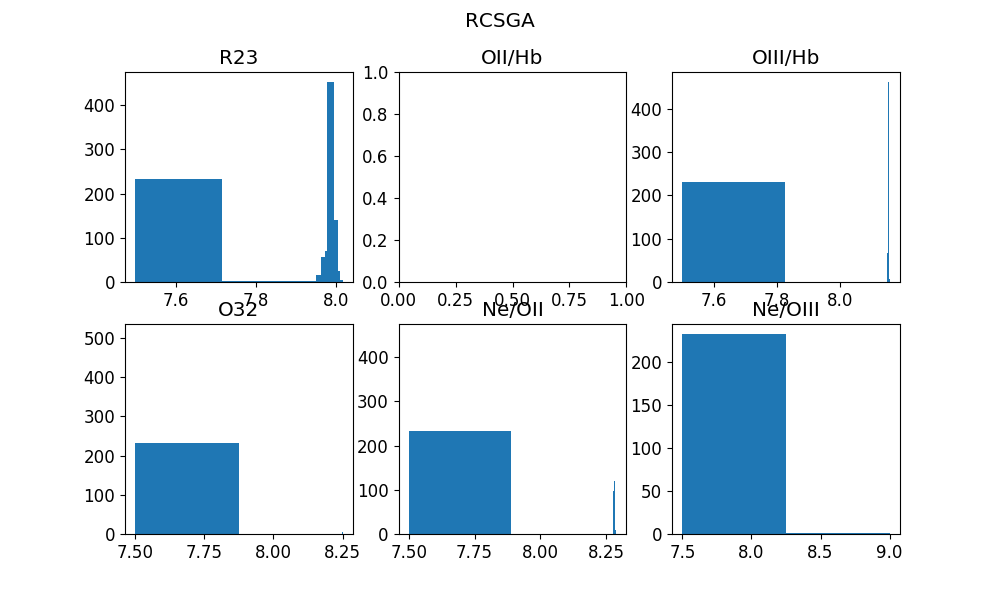

OII_Hb not available


<IPython.core.display.Javascript object>


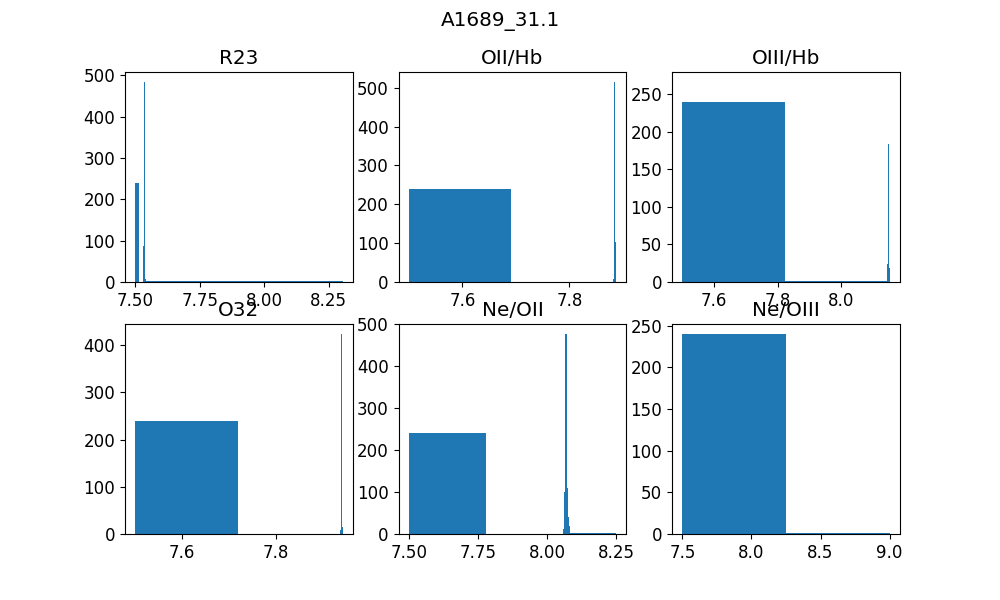

<IPython.core.display.Javascript object>


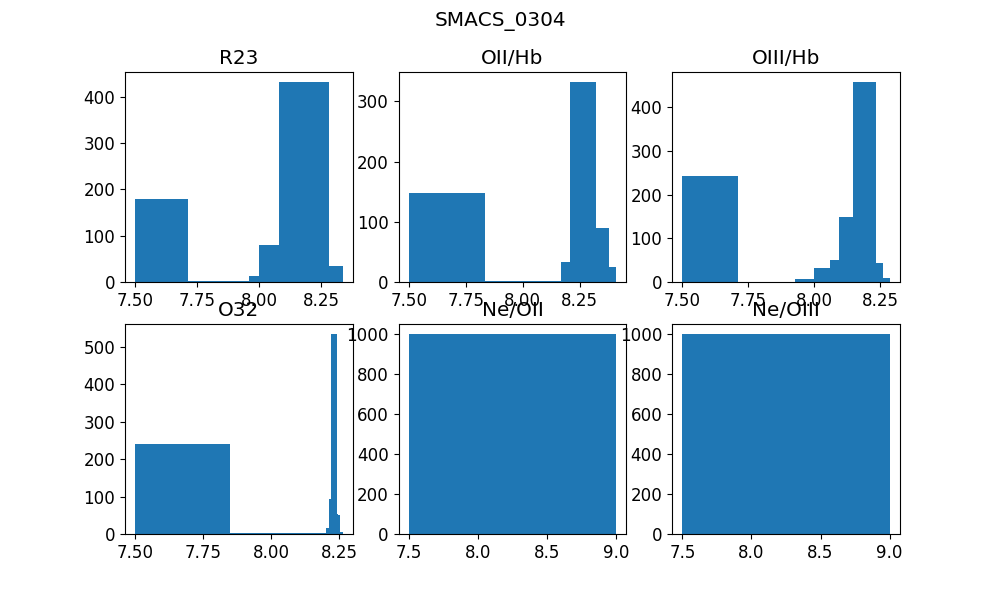

<IPython.core.display.Javascript object>


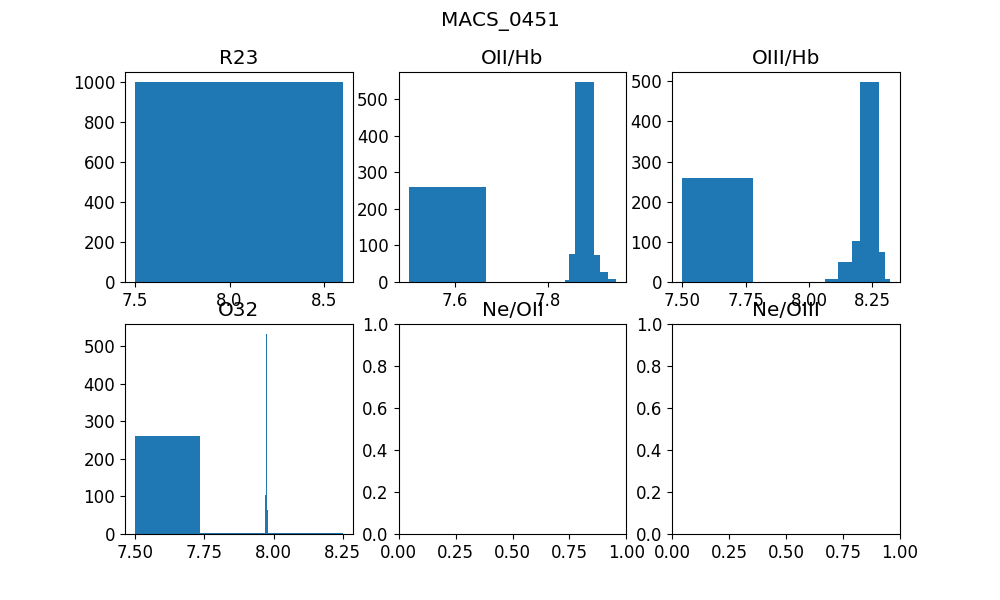

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


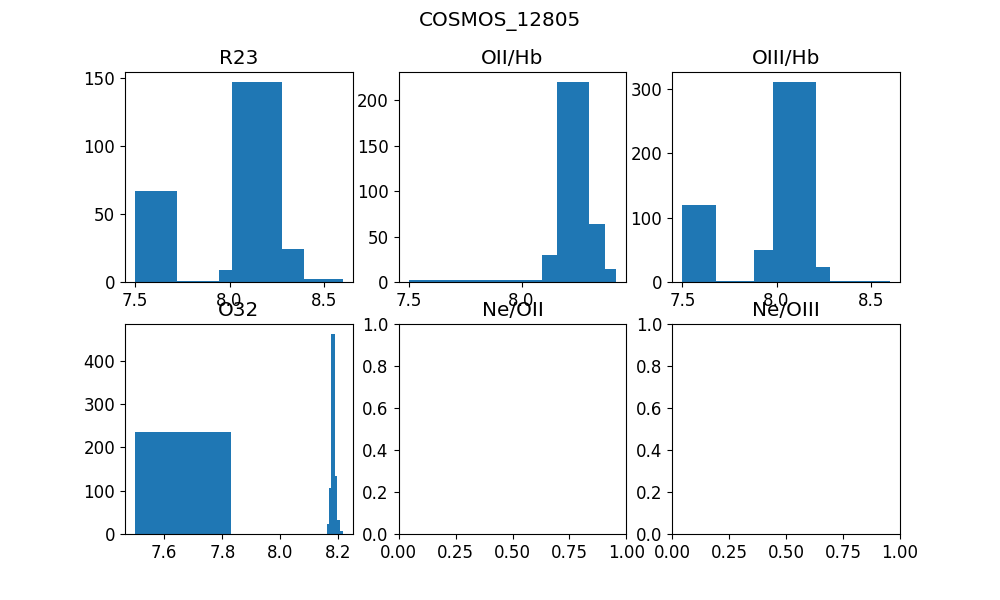

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


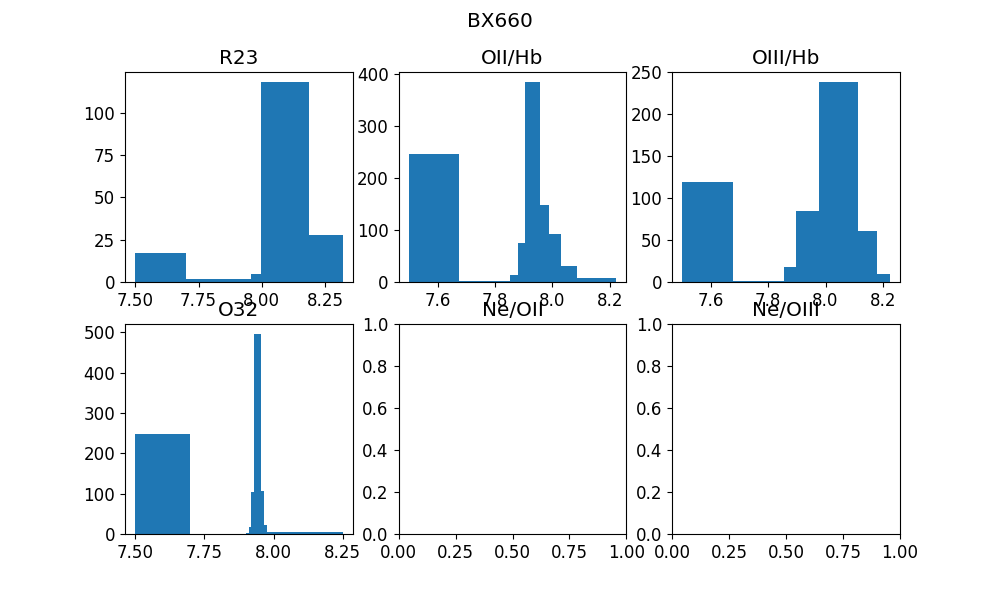

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


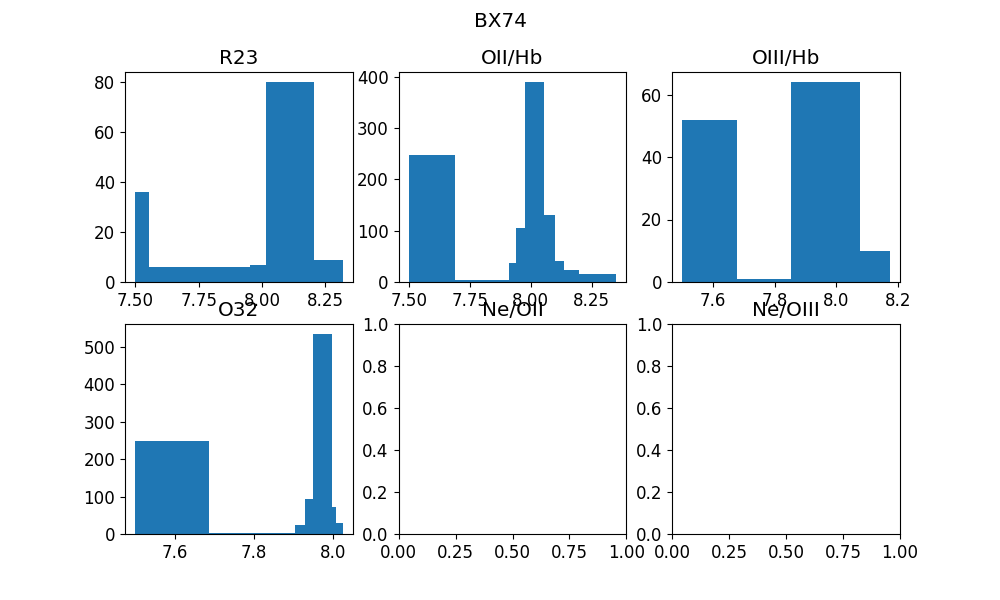

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


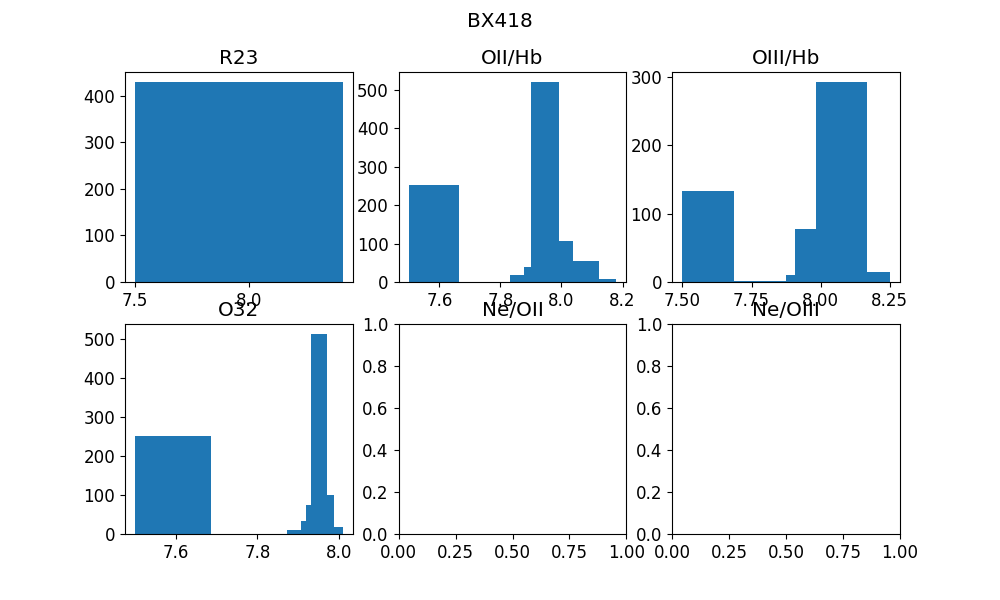

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


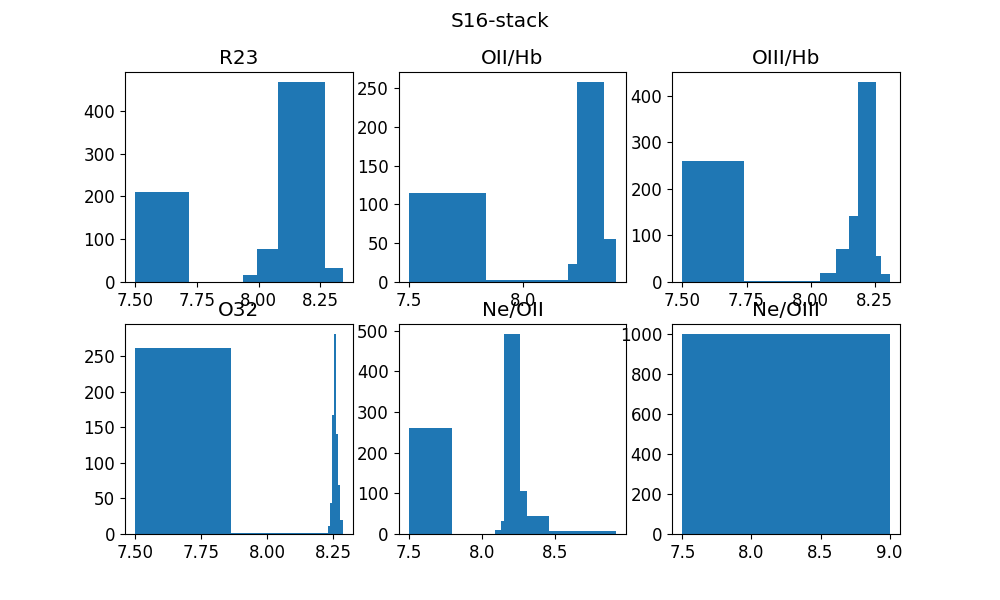

<IPython.core.display.Javascript object>


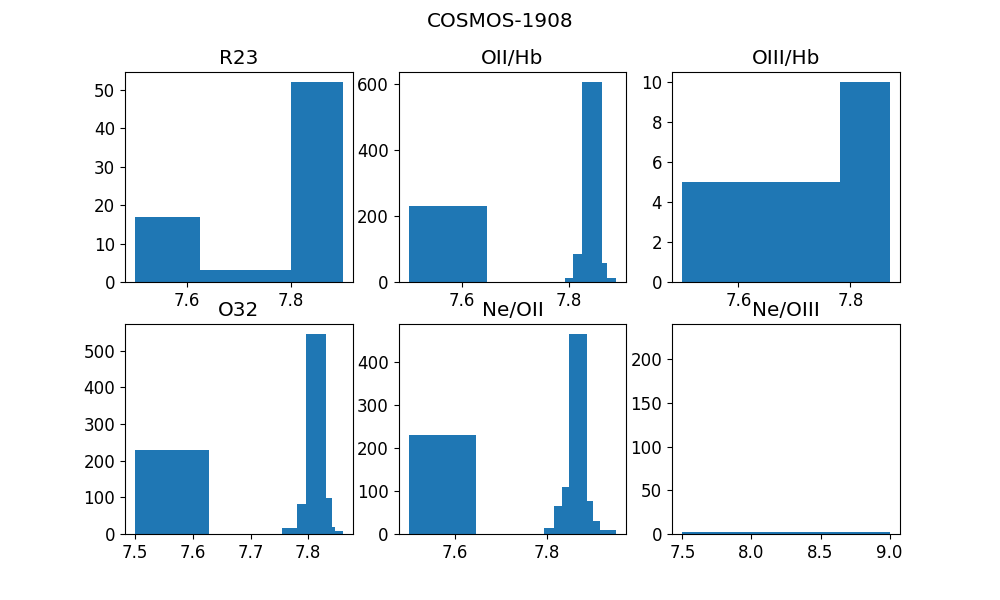

<IPython.core.display.Javascript object>


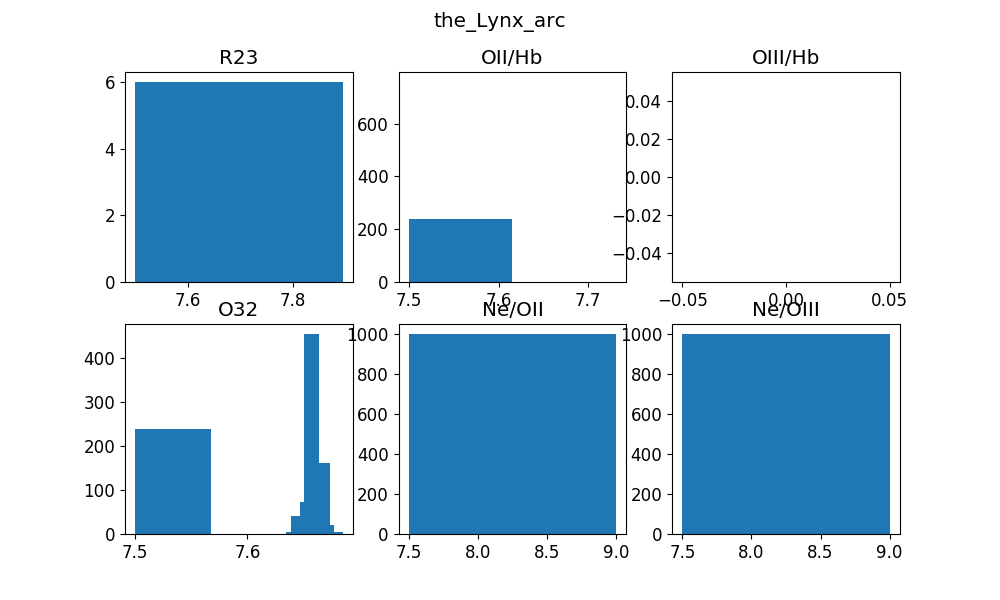

<IPython.core.display.Javascript object>


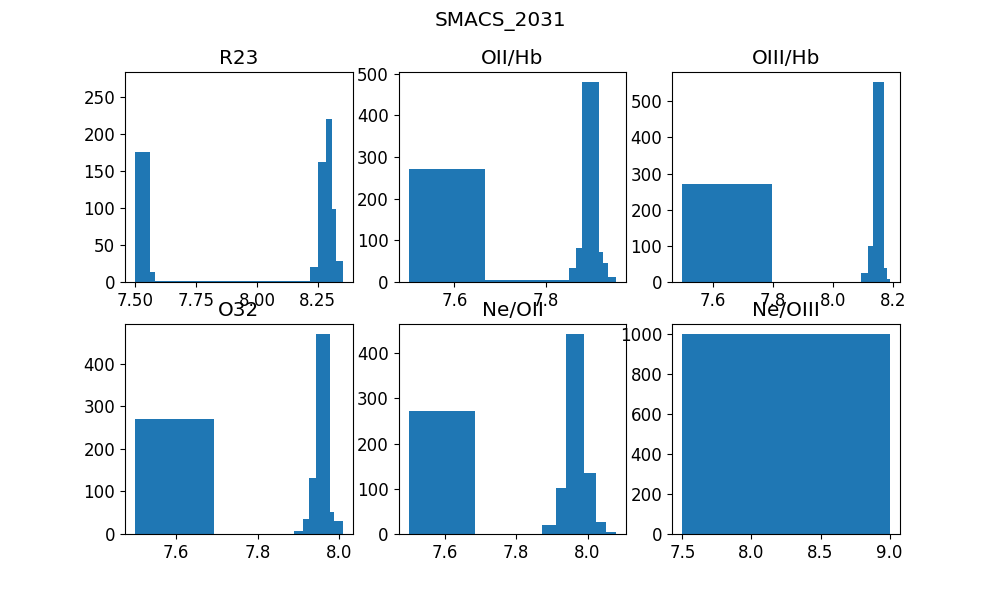

<IPython.core.display.Javascript object>


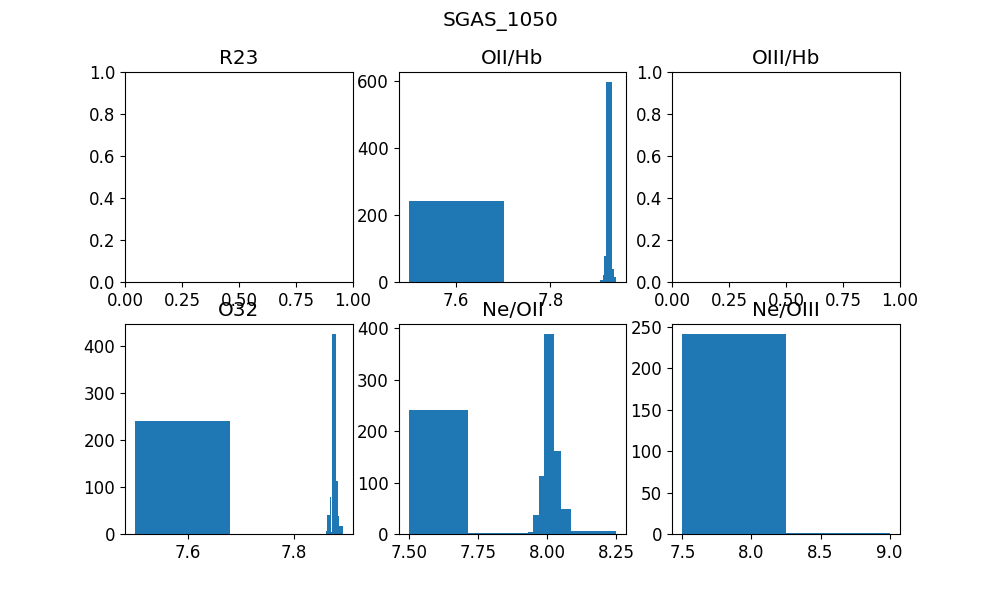

R23 not available
OIII_Hb not available


In [17]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')
gal = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
gal.add_index('Name')


#Initialise table to save results
jones15 = Table(names=['Name','R23','OIII_Hb','O32','OII_Hb','Ne_OII','Ne_OIII',
                             'upR23','upOIII_Hb','upO32','upOII_Hb','upNe_OII','upNe_OIII',
                             'lowR23','lowOIII_Hb','lowO32','lowOII_Hb','lowNe_OII','lowNe_OIII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4',                                 
                                 'f4','f4','f4','f4', 'f4','f4'))

R23_max = 10**0.9671
O3_max = 10**0.8137
O2_max = 10**0.4367

for f_init in dered_fluxes:
    
    R23_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    Ne_OII_sample =[]
    Ne_OIII_sample =[]
    
    for i in range(MC_steps):
        
        f = perturbed_lines(f_init)        

        # Non degenerate calibrations
        init_met = np.random.uniform(low=7.0,high=9.0)
        params = Parameters()
        params.add('met', value=init_met, min=7.6, max=9.0) 
        O32_met = np.nan
    
        ## Ne_OII_sample
        R = f['NeIII3869']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.5, max=9.0)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Jones15))
            Ne_OII_sample.append(fit.params['met'].value)
            
        ## Ne_OIII_sample
        R = f['NeIII3869']/f['OIII5007']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.5, max=9.0)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OIII_5007_Jones15))
            Ne_OIII_sample.append(fit.params['met'].value)    
         
        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.5, max=9.0)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Jones15))
            O32_sample.append(fit.params['met'].value)
            O32_met = fit.params['met'].value
  
        
        # Degenerate diagnostics
        if np.isnan(O32_met):
            continue
        
        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R) and R < R23_max:
            params['met'].set(value=O32_met, min=7.5, max=8.6)
            fit = minimize(minimise_func, params,args=(R,R23_Jones15))
            R23_sample.append(fit.params['met'].value)    

        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R) and R < O3_max:
            params['met'].set(value=O32_met, min=7.5, max=8.6) 
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Jones15))
            OIII_Hb_sample.append(fit.params['met'].value)            

        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R) and R < O2_max:
            params['met'].set(value=O32_met, min=7.5, max=9.0) 
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Jones15))
            OII_Hb_sample.append(fit.params['met'].value)


    # Some plots
    fig, ax = plt.subplots(2,3,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        hist(R23_sample,      bins='blocks',ax=ax[0]) 
    except (ValueError,IndexError):
        print('R23 not available')
    try:
        hist(OII_Hb_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('OII_Hb not available')   
    try:
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        hist(Ne_OII_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('Ne_OII not available') 
    try:
        hist(Ne_OIII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('Ne_OIII not available') 
    
    
    ax[0].set_title('R23')
    ax[1].set_title('OII/Hb')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('Ne/OII')
    ax[5].set_title('Ne/OIII')
        
        
    # Save to table
    jones15.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(Ne_OII_sample,84)-np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,84)-np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(Ne_OII_sample,50)-np.nanpercentile(Ne_OII_sample,16),
        np.nanpercentile(Ne_OIII_sample,50)-np.nanpercentile(Ne_OIII_sample,16)))
                    
jones15.write('Metallicity_Jones15_init_O32.dat',format='ascii.fixed_width_two_line')

### Plot

<IPython.core.display.Javascript object>


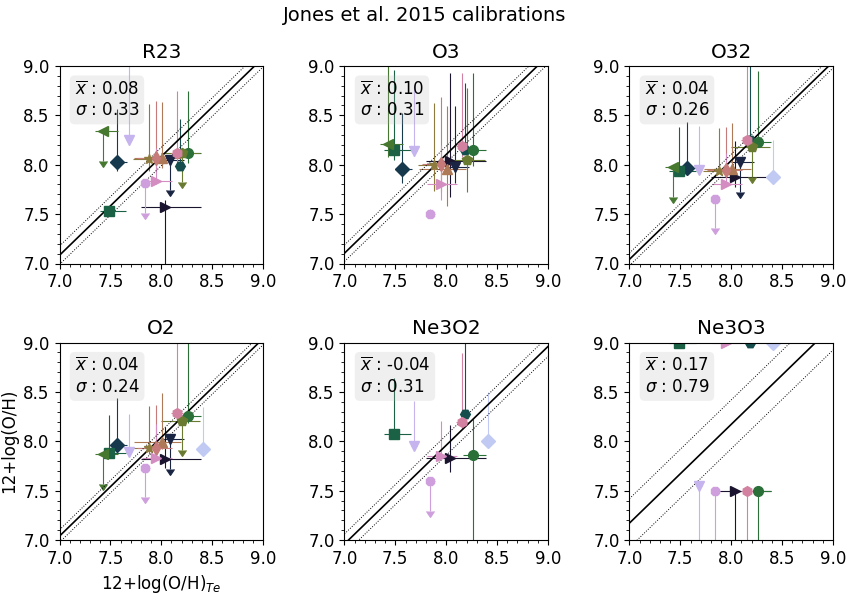

In [18]:
direct_Te = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
jones15 = Table.read('Metallicity_Jones15_init_O32.dat',format='ascii.fixed_width_two_line')
jones15.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Fig
fig, ax = plt.subplots(2,3,figsize=(8.5,6))
fig.subplots_adjust(top=0.89,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
fig.suptitle('Jones et al. 2015 calibrations',fontsize=14,y=0.99)
ax = ax.ravel()
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

diff = []
weights = []

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    nb = s.loc[gal['Name']]['nb']
    
    met = jones15.loc[gal['Name']]
    
    
    # R23
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
         ax[0].errorbar(gal['met'],met['R23'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[0].errorbar(gal['met'],met['R23'],
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr = np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8)
    
    
    # O3
    ax[1].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb']+gal['lowmet'],met['lowOIII_Hb']+gal['upmet'])).reshape(2,1),
                   color=c,marker=m,markersize=7,elinewidth=0.8)   

          
    # O32  
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[2].errorbar(gal['met'],met['O32'],  
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((0.3,0.3)).reshape(2,1),
                   uplims = True ,capthick = 0.8,    
                   color=c,marker=m,markersize=7,elinewidth=0.8)   
    else:
        ax[2].errorbar(gal['met'],met['O32'],  
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 
    # O2
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[3].errorbar(gal['met'],met['OII_Hb'], 
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr = np.array((0.3,0.73)).reshape(2,1),
                   uplims = True ,capthick = 0.8,
                   color=c,marker=m,markersize=7,elinewidth=0.8)
    else: 
        ax[3].errorbar(gal['met'],met['OII_Hb'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 
        
    # Ne3O2
    if gal['Name'] in ['Abell_860_359','MACS_0451','COSMOS_12805','the_Lynx_arc']:
        ax[4].errorbar(gal['met'],met['Ne_OII'], 
               xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
               yerr=np.array((0.3,0.3)).reshape(2,1),
               uplims = True ,capthick = 0.8,
               color=c,marker=m,markersize=7,elinewidth=0.8) 
    else:
        ax[4].errorbar(gal['met'],met['Ne_OII'], 
                       xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                       yerr=np.array((met['upNe_OII'],met['lowNe_OII'])).reshape(2,1),
                       color=c,marker=m,markersize=7,elinewidth=0.8) 

    # Ne3O3
    ax[5].errorbar(gal['met'],met['Ne_OIII'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNe_OIII'],met['lowNe_OIII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    
    # Save results
    diff.append((met['R23']-gal['met'],
                 met['OIII_Hb']-gal['met'],
                 met['O32']-gal['met'],
                 met['OII_Hb']-gal['met'],
                 met['Ne_OII']-gal['met'],
                 met['Ne_OIII']-gal['met']))
    
# fix data format
diff = np.array(diff).T
stats = []

# calculate the rms and std
for i in range(6):
    
    # statistics
    data = diff[i][~np.isnan(diff[i])]
    mean = np.mean(data)
    mean_std = bootstrap(data,500,'mean')
    std = np.std(data) 
    std_std = bootstrap(data,500,'std')   
    mae = mean_absolute_error(np.zeros_like(data),data)
    mae_std = bootstrap(data,500,'mae')
    stats.append((mean,mean_std,std,std_std,mae,mae_std))
    
    #plotting
    ax[i].annotate('$\overline{x}$ : %0.2f\n$\sigma$ : %0.2f'%(mean,std),
                   xy=(7.15,8.5),bbox=dict(boxstyle="round",alpha=0.2,fc="0.7",ec="none"))    
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean,linewidth=1.2,color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean+mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].plot(np.arange(7,10),np.arange(7,10)+mean-mean_std,linewidth=0.7,linestyle=':',color='k')
    ax[i].set_ylim(7.,9.)
    ax[i].set_xlim(7.,9.)
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))   
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))    

# Set titles
ax[0].set_title('R23')
ax[1].set_title('O3')
ax[2].set_title('O32')
ax[3].set_title('O2')
ax[4].set_title('Ne3O2')
ax[5].set_title('Ne3O3')
ax[3].set_xlabel('12+log(O/H)$_{Te}$')
ax[3].set_ylabel('12+log(O/H)')

plt.savefig('/Users/vera/Desktop/jones.pdf')


#save to table
o = np.array(stats).T
jones15.add_row({'Name':'MEAN','R23':o[0][0],'OIII_Hb':o[0][1],'O32':o[0][2],'OII_Hb':o[0][3],'Ne_OII':o[0][4],
                             'Ne_OIII':o[0][5],
                             'upR23':o[1][0],'upOIII_Hb':o[1][1],'upO32':o[1][2],'upOII_Hb':o[1][3],'upNe_OII':o[1][4],
                             'upNe_OIII':o[1][5]})

jones15.add_row({'Name':'STD','R23':o[2][0],'OIII_Hb':o[2][1],'O32':o[2][2],'OII_Hb':o[2][3],'Ne_OII':o[2][4],
                             'Ne_OIII':o[2][5],
                             'upR23':o[3][0],'upOIII_Hb':o[3][1],'upO32':o[3][2],'upOII_Hb':o[3][3],'upNe_OII':o[3][4],
                             'upNe_OIII':o[3][5]})

jones15.add_row({'Name':'MAE','R23':o[4][0],'OIII_Hb':o[4][1],'O32':o[4][2],'OII_Hb':o[4][3],'Ne_OII':o[4][4],
                             'Ne_OIII':o[4][5],
                             'upR23':o[5][0],'upOIII_Hb':o[5][1],'upO32':o[5][2],'upOII_Hb':o[5][3],'upNe_OII':o[5][4],
                             'upNe_OIII':o[5][5]})
jones15.write('Metallicity_Jones15_init_O32.dat',format='ascii.fixed_width_two_line')

## Summary for paper

In [21]:
m08 = Table.read('Metallicity_Maiolino08_init_O32.dat',format='ascii.fixed_width_two_line')
m08.add_index('Name')
c17    = Table.read('Metallicity_Curti17_init_O32.dat',format='ascii.fixed_width_two_line')
c17.add_index('Name')
j15    = Table.read('Metallicity_Jones15_init_O32.dat',format='ascii.fixed_width_two_line')
j15.add_index('Name')

calibs = ['R23','NII_Ha',"OIII_Hb","O32","OII_Hb","OIII_NII","Ne_OII"]

jones_intrinsic = {'R23':0.06,'NII_Ha':np.nan,"OIII_Hb":0.10,"O32":0.23,"OII_Hb":0.15,"OIII_NII":np.nan,"Ne_OII":0.22}
curti_intrinsic = {'R23':0.12,'NII_Ha':0.10,"OIII_Hb":0.07,"O32":0.14,"OII_Hb":0.26,"OIII_NII":0.09,"Ne_OII":np.nan}

# Structure
#          M08         J15              C17
#NB_GAL MAE STD  MAE STD Intrinsic MAE STD Intrinsic

for calib in calibs:
    
    try:
        c17[calib],c17['up'+calib]
        
    except KeyError:
        print('%s & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f \\\\'
              %(calib, 
                np.count_nonzero(~np.isnan(m08[calib])) - 3, # MEAN, MAE and STD
                m08.loc['MEAN'][calib],m08.loc['MEAN']['up'+calib],m08.loc['STD'][calib],m08.loc['STD']['up'+calib],
                np.count_nonzero(~np.isnan(j15[calib])) - 3,
                j15.loc['MEAN'][calib],j15.loc['MEAN']['up'+calib],j15.loc['STD'][calib],j15.loc['STD']['up'+calib],
                jones_intrinsic[calib],
                0,np.nan,np.nan,np.nan,np.nan,curti_intrinsic[calib]))  
        continue
            
    try:
        j15[calib],j15['up'+calib]
    except KeyError:
        print('%s & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f \\\\'
          %(calib, 
            np.count_nonzero(~np.isnan(m08[calib]))- 3,
            m08.loc['MEAN'][calib],m08.loc['MEAN']['up'+calib],m08.loc['STD'][calib],m08.loc['STD']['up'+calib],
            0,np.nan,np.nan,np.nan,np.nan,jones_intrinsic[calib],
            np.count_nonzero(~np.isnan(c17[calib])) - 3,
            c17.loc['MEAN'][calib],c17.loc['MEAN']['up'+calib],c17.loc['STD'][calib],c17.loc['STD']['up'+calib],
            curti_intrinsic[calib]))    
        continue
        
    print('%s & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f & %d & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f \\\\'
          %(calib, 
            np.count_nonzero(~np.isnan(m08[calib]))- 3,
            m08.loc['MEAN'][calib],m08.loc['MEAN']['up'+calib],m08.loc['STD'][calib],m08.loc['STD']['up'+calib],
            np.count_nonzero(~np.isnan(j15[calib])) - 3,
            j15.loc['MEAN'][calib],j15.loc['MEAN']['up'+calib],j15.loc['STD'][calib],j15.loc['STD']['up'+calib],
            jones_intrinsic[calib],
            np.count_nonzero(~np.isnan(c17[calib])) - 3,
            c17.loc['MEAN'][calib],c17.loc['MEAN']['up'+calib],c17.loc['STD'][calib],c17.loc['STD']['up'+calib],
            curti_intrinsic[calib]))    
        

R23 & 12 & -0.04$\pm$0.06 & 0.20$\pm$0.03 & 15 & 0.08$\pm$0.09 & 0.33$\pm$0.07 & 0.06 & 15 & 0.01$\pm$0.04 & 0.17$\pm$0.03 & 0.12 \\
NII_Ha & 10 & 0.14$\pm$0.07 & 0.21$\pm$0.04 & 0 & nan$\pm$nan & nan$\pm$nan & nan & 10 & 0.16$\pm$0.07 & 0.21$\pm$0.05 & 0.10 \\
OIII_Hb & 13 & -0.09$\pm$0.05 & 0.18$\pm$0.03 & 15 & 0.10$\pm$0.08 & 0.31$\pm$0.06 & 0.10 & 13 & 0.03$\pm$0.05 & 0.17$\pm$0.03 & 0.07 \\
O32 & 16 & -0.24$\pm$0.10 & 0.40$\pm$0.06 & 16 & 0.04$\pm$0.06 & 0.26$\pm$0.05 & 0.23 & 16 & -0.01$\pm$0.08 & 0.32$\pm$0.06 & 0.14 \\
OII_Hb & 16 & 0.23$\pm$0.06 & 0.23$\pm$0.04 & 15 & 0.04$\pm$0.06 & 0.24$\pm$0.04 & 0.15 & 16 & -0.02$\pm$0.06 & 0.24$\pm$0.05 & 0.26 \\
OIII_NII & 10 & 0.18$\pm$0.07 & 0.21$\pm$0.05 & 0 & nan$\pm$nan & nan$\pm$nan & nan & 10 & 0.39$\pm$0.07 & 0.22$\pm$0.05 & 0.09 \\
Ne_OII & 9 & -0.20$\pm$0.15 & 0.44$\pm$0.06 & 9 & -0.04$\pm$0.10 & 0.31$\pm$0.06 & 0.22 & 0 & nan$\pm$nan & nan$\pm$nan & nan \\


## HII-CHI-mistry

From the website:
>These files represent the whole set of models, limiting the values of log U at each Z (left picture), and limiting also the values of N/O, respectively (right picture).
All were calculated with Cloudy v.13 and a POPSTAR SED at an age of 1Myr with an IMF of Chabrier.


HII-CHI-mistry has two codes: one for UV and other for optical, which means may be a problem:

Optical:
    * [OII] 3727/Hbeta
    * [OIII] 4363/Hbeta
    * [OIII] 5007/Hbeta
    * [NII] 6584/Hbeta
    * [SII] 6717+6731/Hbeta

UV:
    * Lya HI 1216
    * CIV    1549
    * OIII]  1665
    * CIII   1909
    * Hb HI  4861
    * [OIII] 5007


In [35]:
## Save files in the HII-CHI-mistry format: text file with 5 columns with extinction corrected fluxes
def err_ratio(x,y,e_x,e_y):
    """ Formal Error of x/y """
    return x/y * np.sqrt((e_x/x)**2 + (e_y/y)**2)

dered_fluxes = Table.read('../TeMethod/data_dered_hb_norm.dat',format='ascii.fixed_width_two_line')

def fix_upper_limits(f):
    lines = ['OIITot','OIII4363','OIII5007','NII6584','Hb']
    for l in lines:
        if np.isfinite(f[l]) and np.isnan(f['e'+l]):
            f["e"+l] = 0. # This is very wrong but HII-CHI-MISTRY intreperts 0 as not having an error available
            print('Fixing',l,'in',f['Name'])
    return f
    

for gal in dered_fluxes:
     
    #gal = fix_upper_limits(gal)
    
    # With auroral line
    if np.isfinite( gal['OIII4363']):
        f = open('CHImistry/with_auroral_line/'+gal['Name']+'_Optical.dat','w')
        f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
                 (gal['OIITot'],gal['eOIITot'], gal['OIII4363'],gal['eOIII4363'],
                 gal['OIII5007'],gal['eOIII5007'],gal['NII6584'],gal['eNII6584'],                                    
                 0.0,0.0))
        f.close()   
    
    # All galaxies: No auroral line
    f = open('CHImistry/no_auroral_line/'+gal['Name']+'_Optical.dat','w')
    f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
             #[OII] 3727/Hbeta  
             (gal['OIITot'],gal['eOIITot'],
             # [OIII] 4363/Hbeta 
             0.0,0.0,
             # [OIII] 5007/Hbeta
             gal['OIII5007'],gal['eOIII5007'],                                  
             # [NII] 6584/Hbeta  
             gal['NII6584'],gal['eNII6584'],                                    
             # [SII] 6717+6731/Hbeta
             0.0,0.0))
    f.close()   

In [36]:
## Results only in galaxies with [OII]4363
import glob
from HCm_v3_less_verbose import HII_CHIm

MetOH = []
eMetOH = []
MetNO = []
eMetNO =[]
U = []
eU = []
name = []

for inputfile in glob.glob('CHImistry/with_auroral_line/*_Optical.dat'):
    iMetOH,ieMetOH,iMetNO,ieMetNO,iU,ieU = HII_CHIm(1,inputfile,inputfile.replace('.dat','_out'))
    MetOH.append(iMetOH)
    eMetOH.append(ieMetOH)
    MetNO.append(iMetNO)
    eMetNO.append(iMetNO)
    U.append(iU)
    eU.append(ieU)
    name.append(inputfile.replace('CHImistry/with_auroral_line/','').replace('_Optical.dat',''))
    
## Save results
HCm_out = Table([name,MetOH,eMetOH,MetNO,eMetNO,U,eU],
                names = ['Name','12+log(O/H)','err_OH','log(N/O)','err_NO','U','errU'])
HCm_out.write('Metallicity_HCmistry_with_auroral_lines.dat',format='ascii.fixed_width_two_line')
HCm_out.show_in_notebook()   

---------------------------------------------------------------------
Reading file CHImistry/with_auroral_line/A1689_31.1_Optical.dat

The grid has a resolution 0f 0.02dex for O/H and 0.025dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.506 0.123  -10.0 0.0  -1.932 0.001
---------------------------------------------------------------------
Reading file CHImistry/with_auroral_line/Abell_22.3_Optical.dat

The grid has a resolution 0f 0.02dex for O/H and 0.025dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.69 0.263  -1.225 0.257  -2.085 0.116
---------------------------------------------------------------------
Re

In [37]:
## With all lines except the auroral line and error propagated with MC
MetOH = []
eMetOH = []
MetNO = []
eMetNO =[]
U = []
eU = []
name = []

for inputfile in glob.glob('CHImistry/no_auroral_line/*_Optical.dat'):
    iMetOH,ieMetOH,iMetNO,ieMetNO,iU,ieU = HII_CHIm(1,inputfile,inputfile.replace('.dat','_out'))
    MetOH.append(iMetOH)
    eMetOH.append(ieMetOH)
    MetNO.append(iMetNO)
    eMetNO.append(iMetNO)
    U.append(iU)
    eU.append(ieU)
    name.append(inputfile.replace('CHImistry/no_auroral_line/','').replace('_Optical.dat',''))

## Save results
HCm_out = Table([name,MetOH,eMetOH,MetNO,eMetNO,U,eU],
                names = ['Name','12+log(O/H)','err_OH','log(N/O)','err_NO','U','errU'])
HCm_out.write('Metallicity_HCmistry_no_auroral_lines.dat',format='ascii.fixed_width_two_line')
HCm_out.show_in_notebook()   

---------------------------------------------------------------------
Reading file CHImistry/no_auroral_line/A1689_31.1_Optical.dat

The grid has a resolution 0f 0.02dex for O/H and 0.025dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 3  7.821 0.035  -10.0 0.0  -2.205 0.0
---------------------------------------------------------------------
Reading file CHImistry/no_auroral_line/Abell_22.3_Optical.dat

The grid has a resolution 0f 0.02dex for O/H and 0.025dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 2  8.04 0.1  -1.525 0.161  -2.283 0.096
---------------------------------------------------------------------
Reading fi

In [22]:
## Kojima results on N/O and ionisation parameter

Objects = ['COSMOS_12805',"SMACS_0304","BX74","BX418","BX660","the_Lynx_arc","Abell_22.3","SGAS_1050","CSWA20",
           "MACS_0451","Abell_860_359","S16-stack"]

LogNO =    [-1.3,  -1.57, -1.26, -0.99, -1.39,  -1.02,  -1.74, -1.45,  -1.50, -1.33,  -1.32, -1.21]
upLogNO =  [0,      0.18,  0.11,  0.08,    0 ,   0.09,      0,  0.16,   0.14,    0 ,    0   , 0.03]
lowLogNO = [np.inf, 0.03,  0.14,  0.10, np.inf,  0.08, np.inf,  0.20,   0.18, np.inf, np.inf, 0.03]

LogQ     = [7.75,   7.91, 8.16, 8.20, 8.24, 8.64,   7.74, 8.55, 8.03, 8.02,   8.12,   7.70] 
upLogQ   = [np.inf, 0.03, 0.09, 0.04, 0.04, np.inf, 0.12, 0.04, 0.09, np.inf, np.inf, 0.02]
lowLogQ  = [0,      0.03, 0.10, 0.05, 0.05,  0     , 0.09, 0.03, 0.07, 0,       0,     0.02]

kojima = Table(data=(Objects,LogNO,upLogNO,lowLogNO,LogQ,upLogQ,lowLogQ),
               names = ['Name','LogNO','upLogNO','lowLogNO','LogQ','upLogQ','lowLogQ'])
kojima.add_index('Name')
kojima.show_in_notebook()

<IPython.core.display.Javascript object>


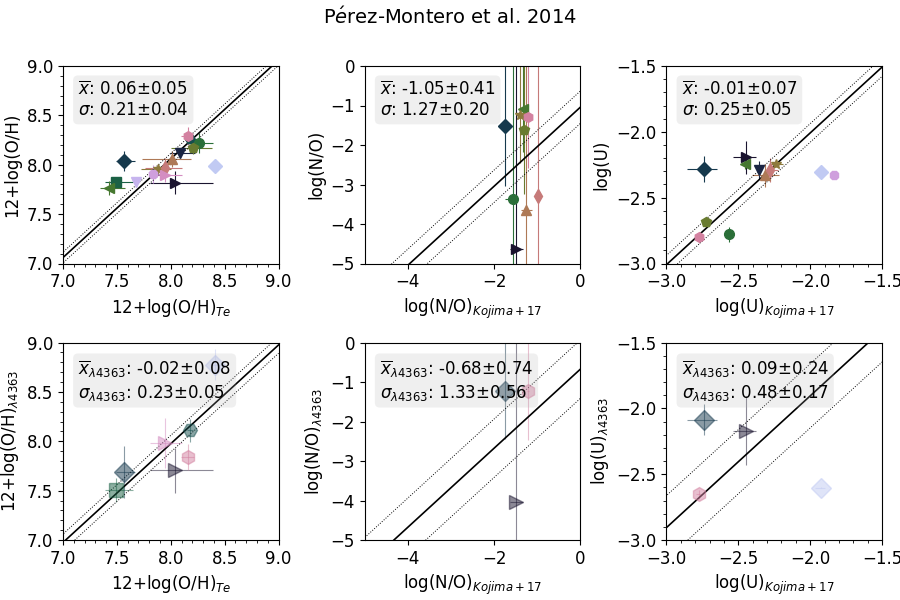

In [23]:
# Plot
direct_Te = Table.read('../TeMethod/direct_metallicity.dat',format='ascii.fixed_width_two_line')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')
direct_Te.add_index('Name')
HCm = Table.read('Metallicity_HCmistry_no_auroral_lines.dat',format='ascii.fixed_width_two_line')
HCm.add_index('Name')
HCm_aur = Table.read('Metallicity_HCmistry_with_auroral_lines.dat',format='ascii.fixed_width_two_line')
HCm_aur.add_index('Name')
cte = np.log10(29979245800)# speed of light in  centimeter / second

# Save values to calculate stats
d_OH = [] # metallicity difference
d_NO = [] # metallicity difference
d_Q = [] # metallicity difference

# Fig
fig, ax = plt.subplots(2,3,figsize=(9.0,6))
fig.subplots_adjust(top=0.89,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
ax = ax.ravel()
fig.suptitle(r'P$\acute{e}$rez-Montero et al. 2014',fontsize=14,y=0.99)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

for gal in direct_Te:

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    nb = s.loc[gal['Name']]['nb'] + 1
    PM17 = HCm.loc[gal['Name']]

    try:
        PM17_aur = HCm_aur.loc[gal['Name']]
    except KeyError:
        PM17_aur = {'12+log(O/H)':np.nan,"log(N/O)":np.nan,"U":np.nan,
                      'err_OH':np.nan,'err_NO':np.nan,'errU':np.nan}
        
    # Not fitted
    if PM17_aur['log(N/O)'] == -10: # was not fit
        PM17_aur["log(N/O)"] = np.nan
    if PM17['log(N/O)'] == -10: # was not fit
        PM17["log(N/O)"] = np.nan
                    
    try:
        k17 = kojima.loc[gal['Name']]
    except KeyError:
        k17 = {'LogNO':np.nan,'upLogNO':np.nan,'lowLogNO':np.nan,'LogQ':np.nan,'upLogQ':np.nan,'lowLogQ':np.nan}
    
    # OH
    ax[0].errorbar(gal['met'],PM17['12+log(O/H)'],
                   yerr=PM17['err_OH'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[3].errorbar(gal['met'], PM17_aur['12+log(O/H)'],
                   yerr=PM17_aur['err_OH'],
                   xerr = np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=10,elinewidth=0.8,alpha=0.5)
    d_OH.append((PM17['12+log(O/H)']-gal['met'],PM17_aur['12+log(O/H)']-gal['met'])) 

    
    # N/O
    ax[1].errorbar(k17['LogNO'], PM17['log(N/O)'],
                   yerr=PM17['err_NO'],
                   xerr = np.array((k17['upLogNO'],k17['lowLogNO'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[4].errorbar(k17['LogNO'], PM17_aur['log(N/O)'],
                   yerr=PM17_aur['err_NO'],
                   xerr = np.array((k17['upLogNO'],k17['lowLogNO'])).reshape(2,1),
                   marker=m,color=c,markersize=10,elinewidth=0.8,alpha=0.5)
    d_NO.append((PM17['log(N/O)']-k17['LogNO'],PM17_aur['log(N/O)']-k17['LogNO'])) 


    # Q
    ax[2].errorbar(k17['LogQ']-cte, PM17['U'], # to make it adimenstional as PM17
                   yerr=PM17['errU'],
                   xerr = np.array((k17['upLogQ'],k17['lowLogQ'])).reshape(2,1),
                  marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[5].errorbar(k17['LogQ']-cte, PM17_aur['U'],
                   yerr=PM17_aur['errU'],
                   xerr = np.array((k17['upLogQ'],k17['lowLogQ'])).reshape(2,1),
                   marker=m,color=c,markersize=10,elinewidth=0.8,alpha=0.5)
    d_Q.append((PM17['U']-(k17['LogQ']-cte),PM17_aur['U']-(k17['LogQ']-cte)))

    
## Plotting
# OH
ax[0].set_ylabel('12+log(O/H)')
ax[3].set_ylabel('12+log(O/H)$_{\lambda4363}$')
ax[0].set_xlabel('12+log(O/H)$_{Te}$')
ax[3].set_xlabel('12+log(O/H)$_{Te}$')
ax[0].set_ylim(7,9)
ax[0].set_xlim(7,9)
ax[3].set_ylim(7,9)
ax[3].set_xlim(7,9)

# OH
ax[1].set_ylabel('log(N/O)')
ax[1].set_xlabel('log(N/O)$_{Kojima+17}$')
ax[4].set_ylabel('log(N/O)$_{\lambda4363}$')
ax[4].set_xlabel('log(N/O)$_{Kojima+17}$')
ax[1].set_ylim(-5,0)
ax[1].set_xlim(-5,0)
ax[4].set_ylim(-5,0)
ax[4].set_xlim(-5,0)

# Q
ax[2].set_ylabel('log(U)')
ax[2].set_xlabel('log(U)$_{Kojima+17}$')
ax[5].set_ylabel('log(U)$_{\lambda4363}$')
ax[5].set_xlabel('log(U)$_{Kojima+17}$')
ax[2].set_ylim(-3,-1.5)
ax[2].set_xlim(-3,-1.5)
ax[5].set_ylim(-3,-1.5)
ax[5].set_xlim(-3,-1.5)

# Stats
for i,d in enumerate((d_OH,d_NO,d_Q)):
    
    data = np.array(d).T[0]
    data = np.array(data)[np.isfinite(data)]
    mean = np.mean(data)
    mean_std = bootstrap(data,500,'mean')
    std = np.std(data) 
    std_std = bootstrap(data,500,'std')   
    mae = mean_absolute_error(np.zeros_like(data),data)
    mae_std = bootstrap(data,500,'mae')
    
    data_aur = np.array(d).T[1]
    data_aur = np.array(data_aur)[np.isfinite(data_aur)]
    mean_aur = np.mean(data_aur)
    mean_std_aur = bootstrap(data_aur,500,'mean')
    std_aur = np.std(data_aur) 
    std_std_aur = bootstrap(data_aur,500,'std')   
    mae_aur = mean_absolute_error(np.zeros_like(data_aur),data_aur)
    mae_std_aur = bootstrap(data_aur,500,'mae')
    
    # Plotting
    ax[i].annotate('$\overline{x}$: %0.2f$\pm$%0.2f\n$\sigma$: %0.2f$\pm$%0.2f'%(mean,mean_std,std,std_std),
                   xy=(.07, .75), xycoords='axes fraction',bbox=dict(boxstyle="round",alpha=0.2,fc="0.7",ec="none"))
    ax[i+3].annotate('$\overline{x}_{\lambda4363}$: %0.2f$\pm$%0.2f\n$\sigma_{\lambda4363}$: %0.2f$\pm$%0.2f'
                   %(mean_aur,mean_std_aur,std_aur, std_std_aur),
                    xy=(.07, .72), xycoords='axes fraction',bbox=dict(boxstyle="round",alpha=0.2,fc="0.7",ec="none"))

    ax[i].plot(range(-5,10),range(-5,10)+mean,linewidth=1.2,color='k')
    ax[i].plot(range(-5,10),range(-5,10)+mean+mean_std,color='k',linewidth=0.7,linestyle=':')
    ax[i].plot(range(-5,10),range(-5,10)+mean-mean_std,color='k',linewidth=0.7,linestyle=':')
    ax[i+3].plot(range(-5,10),range(-5,10)+mean_aur,linewidth=1.2,color='k')
    ax[i+3].plot(range(-5,10),range(-5,10)+mean_aur+mean_std_aur,color='k',linewidth=0.7,linestyle=':')
    ax[i+3].plot(range(-5,10),range(-5,10)+mean_aur-mean_std_aur,color='k',linewidth=0.7,linestyle=':')

for i in [0,2]:
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))   
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))    
    ax[i+3].yaxis.set_minor_locator(MultipleLocator(0.1))   
    ax[i+3].xaxis.set_minor_locator(MultipleLocator(0.1))    



#Save to Table 
#HCm.add_row({'Name':'STD','12+log(O/H)':std,'err_OH':std_std})
#HCm.add_row({'Name':'MAE','12+log(O/H)':mae,'err_OH':mae_std})

#HCm.write('Metallicity_HCmistry.dat',format='ascii.fixed_width_two_line')
fig.savefig('/Users/vera/Desktop/HCm.pdf')